# Post-earnings announcement drift

2024/4/23 姚葳、沈华傲、杨瑞维

分工情况：各自完成代码，一起讨论解决遇到的问题

在第11章中，我们看到“好消息”公司和“坏消息”公司的累积收益即使在收益公告之后也继续偏离。这一结果被认为是一种市场异象，因为一旦公布收益，有效市场就会迅速吸收这些收益的含义，而且不应该与随后的超额回报有任何关联。随后的研究在Ball和Brown(1968)的基础上进行了扩展，发现盈余公告后漂移(“PEAD”)存在，并采用了更精细的测量和方法。

PEAD研究的一个核心概念是盈余意外（earnings suprise），可以大致定义为实际收益减去预期收益。因此，要衡量盈余意外，我们需要衡量预期收益。早期的研究使用收益的时间序列模型来开发收益预期模型。我们将仔细研究Foster（1977），这是对季度会计数据行为的早期研究。

# 本地数据获取

In [1]:
import os
import re
import pandas as pd
import numpy as np
from datetime import datetime
from time import time
import sqlite3
import statsmodels.api as sm
# from sklearn.linear_model import LinearRegression
from joblib import Parallel, delayed
from plotnine import *

In [2]:
pead = sqlite3.connect(database='pead.sqlite')
pead.execute('SELECT name FROM sqlite_master').fetchall() # 其中的rets数据库是由R代码计算得出的，之后要用到

[('fundq',), ('ccmxpf_lnkhist',), ('company',), ('rets',), ('funda',)]

In [3]:
funda = pd.read_sql_query(sql='SELECT * FROM funda', 
                          con=pead,
                          dtype={"gvkey": str},
                          parse_dates={'datadate','apdedate','fdate','pdate'})

In [4]:
funda

,indfmt,datafmt,consol,popsrc,gvkey,datadate,apdedate,fdate,pdate,fyear,fyr,sale,ni
0,INDL,STD,C,D,001000,1961-12-31,NaT,NaT,NaT,1961.0,12.0,0.900,NaN
1,INDL,STD,C,D,001000,1962-12-31,NaT,NaT,NaT,1962.0,12.0,1.600,NaN
2,INDL,STD,C,D,001000,1963-12-31,NaT,NaT,NaT,1963.0,12.0,1.457,0.003
3,INDL,STD,C,D,001000,1964-12-31,NaT,NaT,NaT,1964.0,12.0,2.032,0.052
4,INDL,STD,C,D,001000,1965-12-31,NaT,NaT,NaT,1965.0,12.0,1.688,-0.197
...,...,...,...,...,...,...,...,...,...,...,...,...,...
897555,INDL,STD,C,D,353742,2023-11-30,2023-11-30,2024-04-13,2024-04-04,2023.0,11.0,0.000,3.549
897556,INDL,SUMM_STD,C,D,353742,2023-11-30,NaT,NaT,NaT,2023.0,11.0,0.000,3.549
897557,INDL,STD,C,D,353945,2021-12-31,2021-12-31,2022-10-13,NaT,2021.0,12.0,756.466,138.508
897558,INDL,STD,C,D,356128,2022-12-31,2022-12-31,2024-01-27,NaT,2022.0,12.0,2746.982,1264.809


##### funda数据说明
- indfmt：行业格式。这个字段指示了报告使用的行业数据标准格式，例如“INDL”代表工业标准格式。

- datafmt：数据格式。这个字段指明了财务数据的表现形式，如“STD”代表标准格式。

- consol：合并标志。这个字段表示财务数据是基于单一公司的，还是基于整个公司集团的合并报告。例如，“C”代表合并数据。

- popsrc：数据来源。这个字段标识了数据的来源，比如“D”通常表示直接从公司获取的数据。

- gvkey：全局公司键值。这是 Compustat 分配给每个公司的唯一标识符，用于唯一标识数据库中的公司。

- datadate：数据日期。这个字段表示财务报告的日期，通常是财务年度的最后一天。

- apdedate：数据的实际的期末日期

- pdate：数据初步更新的日期

- fadte：数据最终确定的日期

- fyear：财务年度。这个字段表示报告所属的会计年度。

- fyr：财务年度末月份。这个字段表示公司的会计年度结束的月份，用于识别不同公司可能存在的会计年度差异。

- sale：销售总额。这个项目表示销售总额，即在此期间完成的正常销售的实际销售金额，减去现金折扣、商业折扣、退回的销售和给予客户贷方的津贴。

- ni：净收入（Net Income）。这一项目是指公司在会计期间的所有收入和收益(包括特别项目和终止业务)中减去费用和损失后报告的收入或损失。

In [5]:
fundq = pd.read_sql_query(sql='SELECT * FROM fundq',
                          con=pead,
                          dtype={"gvkey": str},
                          parse_dates={'rdq', 'datadate'})

In [6]:
fundq

,indfmt,datafmt,consol,popsrc,fqtr,fyr,rdq,gvkey,datadate,fyearq,saleq,niq,ibq
0,INDL,STD,C,D,1.0,12,NaT,001000,1966-03-31,1966,NaN,NaN,NaN
1,INDL,STD,C,D,2.0,12,NaT,001000,1966-06-30,1966,NaN,NaN,NaN
2,INDL,STD,C,D,3.0,12,NaT,001000,1966-09-30,1966,NaN,NaN,NaN
3,INDL,STD,C,D,4.0,12,NaT,001000,1966-12-31,1966,4.032,0.164,0.141
4,INDL,STD,C,D,1.0,12,NaT,001000,1967-03-31,1967,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005378,INDL,STD,C,D,4.0,12,2024-01-19,356128,2022-12-31,2022,904.689,429.647,429.647
2005379,INDL,STD,C,D,1.0,12,NaT,356128,2023-03-31,2023,NaN,NaN,NaN
2005380,INDL,STD,C,D,2.0,12,NaT,356128,2023-06-30,2023,1852.527,812.541,812.541
2005381,INDL,STD,C,D,3.0,12,2024-01-19,356128,2023-09-30,2023,959.980,438.130,438.130


##### fundq数据说明
- indfmt：行业格式。指示财务数据遵循的行业标准格式，例如“INDL”代表工业公司的标准格式。

- datafmt：数据格式。标识财务数据的表示形式，如“STD”代表标准格式。

- consol：合并标志。表示财务数据是基于单个实体的还是基于一个公司集团的合并数据。例如，“C”表示合并数据。

- popsrc：数据来源。这个字段标识了数据的来源，例如，“D”通常表示数据直接来自于公司报告。

- fqtr：财务季度。表示报告所涵盖的财务季度，通常是1到4的数字，分别对应一年中的四个季度。

- fyr：财务年度末月份。这个字段表示公司的会计年度结束的月份，用于识别不同公司可能存在的会计年度差异。

- rdq：报告日期（Report Date for Quarterly Data）。表示公司发布季度财务报告的日期。

- gvkey：全局公司键值。这是 Compustat 分配给每个公司的唯一标识符，用于在数据库中唯一标识公司。

- datadate：数据日期。这个字段表示财务报告的日期，通常是财务季度的最后一天。

- fyearq：财务年度。本项目代表本会计年度的年终月。如果当前财政年度的结束月份是在1月到5月之间，这个项目就是当前日历年减去1年。如果当前会计年度的结束月份在6月至12月之间，则该项目为当前日历年度。

- saleq：销售额（季度）。这个项目表示销售总额，即在此期间的正常销售的实际销售金额，减去现金折扣、商业折扣、退回的销售和给予客户贷方的津贴。

- niq：净收入（季度）。这个项目表示公司扣除所有费用后的收入，包括特殊项目、所得税和少数股权，但不包括普通股和/或优先股股息准备金。

- ibq：非经常性项目前收入（季度）（Income Before Extraordinary Items）。这一项目是指公司在会计期间的所有收入和收益(包括特别项目和终止业务)中减去费用和损失后报告的收入或损失。

In [7]:
company = pd.read_sql_query(sql='SELECT * FROM company',
                          con=pead,
                          dtype={"gvkey": str})

In [8]:
company

,gvkey,sic
0,001000,3089
1,001001,5812
2,001002,3825
3,001003,5712
4,001004,5080
...,...,...
53690,353945,3621
53691,354003,6722
53692,354519,3711
53693,356128,6141


##### company数据说明
- gvkey：全局公司键值。这是 Compustat 分配给每个公司的唯一标识符，用于在数据库中唯一标识公司。

- sic：标准行业分类代码（Standard Industry Classification Code）。这一项包含识别业务线的代码，它由一个四位数的数字代码组成。

In [9]:
ccmxpf_lnkhist = pd.read_sql_query(sql='SELECT * FROM ccmxpf_lnkhist',
                                   con=pead,
                                   dtype={"gvkey": str},
                                   parse_dates={'linkenddt', 'linkdt'})
ccmxpf_lnkhist['lpermno'] = ccmxpf_lnkhist['lpermno'].astype("str").apply(lambda x: x[0:5]) # 原数据lpermno格式有问题

In [10]:
ccmxpf_lnkhist

,linktype,linkprim,lpermno,linkenddt,gvkey,linkdt
0,NU,C,nan,1970-09-29,001000,1961-01-01
1,NU,P,nan,1970-11-12,001000,1970-09-30
2,LU,P,25881,1978-06-30,001000,1970-11-13
3,NU,C,nan,1983-09-19,001001,1978-01-01
4,LU,P,10015,1986-07-31,001001,1983-09-20
...,...,...,...,...,...,...
117000,NR,P,nan,NaT,353742,2023-05-31
117001,NR,N,nan,NaT,353742,2023-11-30
117002,NR,P,nan,NaT,353945,2022-10-31
117003,LS,P,23698,NaT,354003,2023-02-24


##### ccmxpf_lnkhist数据说明
- linktype：这个字段指示了链接的类型，即 Compustat 数据和 CRSP 数据之间是如何关联的。不同的类型可能代表不同的链接质量或用途，例如，一些链接可能是基于特定时间段内的一致性检验。

- linkprim：这个字段指明了链接是否为主要链接。因为一个公司可能有多只股票（例如，普通股和优先股），所以这个字段帮助研究人员识别哪些链接指向公司的主要股票。常见值包括 "P" 表示主要普通股，"C" 表示合并（即公司的合并财务报表）。

- lpermno：这是 CRSP 分配给每只股票的永久编号（permno），用于唯一标识 CRSP 数据库中的股票。这个编号是链接 Compustat 和 CRSP 记录的关键字段之一。

- linkenddt：链接结束日期，表示 Compustat 和 CRSP 之间的链接在这个日期或之前有效。如果这个字段为空，可能表示链接一直有效，直到数据库最后更新日期。

- gvkey：这是 Compustat 分配给每个公司的唯一标识符，用于在 Compustat 数据库中唯一标识公司。这个键也是链接 Compustat 和 CRSP 数据的关键字段之一。

- linkdt：链接开始日期，表示 Compustat 和 CRSP 之间的链接从这个日期开始有效。

# 1 财务年度（Fiscal years）

## 1.1 Replication

In [40]:
funda_mod = (funda
             .query('indfmt == "INDL" & datafmt == "STD" & consol == "C" & popsrc == "D"')
            )

会计和金融研究中的一个概念是财务年度。大多数美国公司的财务报告期截至每年的12月31日。大多数澳大利亚公司的财务报告期在每年的6月30日结束。实践中没有统一的财务年度定义，Compustat的fundq数据库中包含有变量fyear，它被描述为“财政年度”。而funda则包含四类Date类型的数据，分别定义如下：

***datadate***：期末日期

***apdedate***：实际的期末日期

***pdate***：数据初步更新的日期

***fadte***：数据最终确定的日期

以苹果公司（代码为001690）为例来观察funda中各个date类型变量的实际含义，可以看出，datadate实际上并不是实际的财年结束时点（“财政年度是在9月的最后一个星期六结束的52或53周期间”），而总是9月的最后一天。同时，其他三种date类型的数据在早期大部分都是空值。同时，还会存在财年调整的问题。

In [17]:
apple_dates = (funda_mod
               .query('gvkey=="001690"')
               .select_dtypes(include=['datetime'])
              )

In [18]:
apple_dates[~apple_dates['apdedate'].isna()].head(6)

,datadate,apdedate,fdate,pdate
20470,2003-09-30,2003-09-27,NaT,NaT
20472,2004-09-30,2004-09-25,NaT,NaT
20474,2005-09-30,2005-09-24,NaT,NaT
20476,2006-09-30,2006-09-30,2007-01-01,2006-10-18
20478,2007-09-30,2007-09-29,2007-11-16,2007-10-22
20480,2008-09-30,2008-09-27,2008-11-05,2008-10-21


In [33]:
# 计算每个财年的长度
(apple_dates
 .sort_values(by=['datadate'])
 .assign(fyear_length = lambda x: x['apdedate'] - x['apdedate'].shift())
 .tail(6)
)

,datadate,apdedate,fdate,pdate,fyear_length
20502,2018-09-30,2018-09-29,2018-11-05,2018-11-01,364 days
20504,2019-09-30,2019-09-28,2019-11-04,2019-10-30,364 days
20506,2020-09-30,2020-09-26,2020-11-02,2020-10-29,364 days
20509,2021-09-30,2021-09-25,2021-11-01,2021-10-28,364 days
20511,2022-09-30,2022-09-24,2022-10-31,2022-10-27,364 days
20513,2023-09-30,2023-09-30,2023-11-04,2023-11-02,371 days


虽然Computstat提供了fyear确定的方法，但我们可以尝试直接使用funda中的datadate和fyear数据来分析fyear和datadate之间关系。

（1）回归一：用fyear对datadate中的month和year进行回归，month定义为虚拟变量，同时不包含截距项。

（2）回归二：用fyear对datadate中的month和year进行回归，month定义为连续变量。

In [68]:
fyear_data = (funda_mod[['fyear','datadate']]
              .drop_duplicates()
              .assign(month = lambda x:x['datadate'].dt.month,
                     year = lambda x:x['datadate'].dt.year)
              .dropna(subset=['fyear'])
             )
fyear_data['fyear'] = fyear_data['fyear'].astype(int)

In [69]:
fyear_data

,fyear,datadate,month,year
0,1961,1961-12-31,12,1961
1,1962,1962-12-31,12,1962
2,1963,1963-12-31,12,1963
3,1964,1964-12-31,12,1964
4,1965,1965-12-31,12,1965
...,...,...,...,...
90998,1953,1954-05-31,5,1954
90999,1957,1958-05-31,5,1958
91000,1958,1959-05-31,5,1959
91001,1959,1960-05-31,5,1960


In [70]:
model1 = sm.formula.ols(formula='fyear ~ C(month) + year - 1', data=fyear_data).fit()
model2 = sm.formula.ols(formula='fyear ~ month + year', data=fyear_data).fit()
fms = [model1, model2]

In [71]:
for idx, model in enumerate(fms):
    print(f"Model {idx + 1} Summary:")
    print(model.summary())
    print(f"\nNumber of observations: {model.nobs}")
    print(f"R-squared: {model.rsquared}\n")

Model 1 Summary:
                            OLS Regression Results                            
Dep. Variable:                  fyear   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 7.417e+27
Date:                Mon, 22 Apr 2024   Prob (F-statistic):               0.00
Time:                        03:26:31   Log-Likelihood:                 22562.
No. Observations:                 886   AIC:                        -4.510e+04
Df Residuals:                     873   BIC:                        -4.504e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
C(month)[1]     -1.0000   6.67e

In [72]:
fyear_plot_data = (fyear_data
                   .assign(pred_1 = fms[0].predict(fyear_data),
                           pred_2 = fms[1].predict(fyear_data),
                           resid_1 = lambda x: x['pred_1'] - x['fyear'], # 计算残差
                           resid_2 = lambda x: x['pred_2'] - x['fyear'])
                  )

In [158]:
plot_sample = (fyear_plot_data
               .query("year in [2001,2002]")
               [['datadate', 'fyear', 'pred_1', 'pred_2']]
               .drop_duplicates()
               .sort_values(by='datadate'))

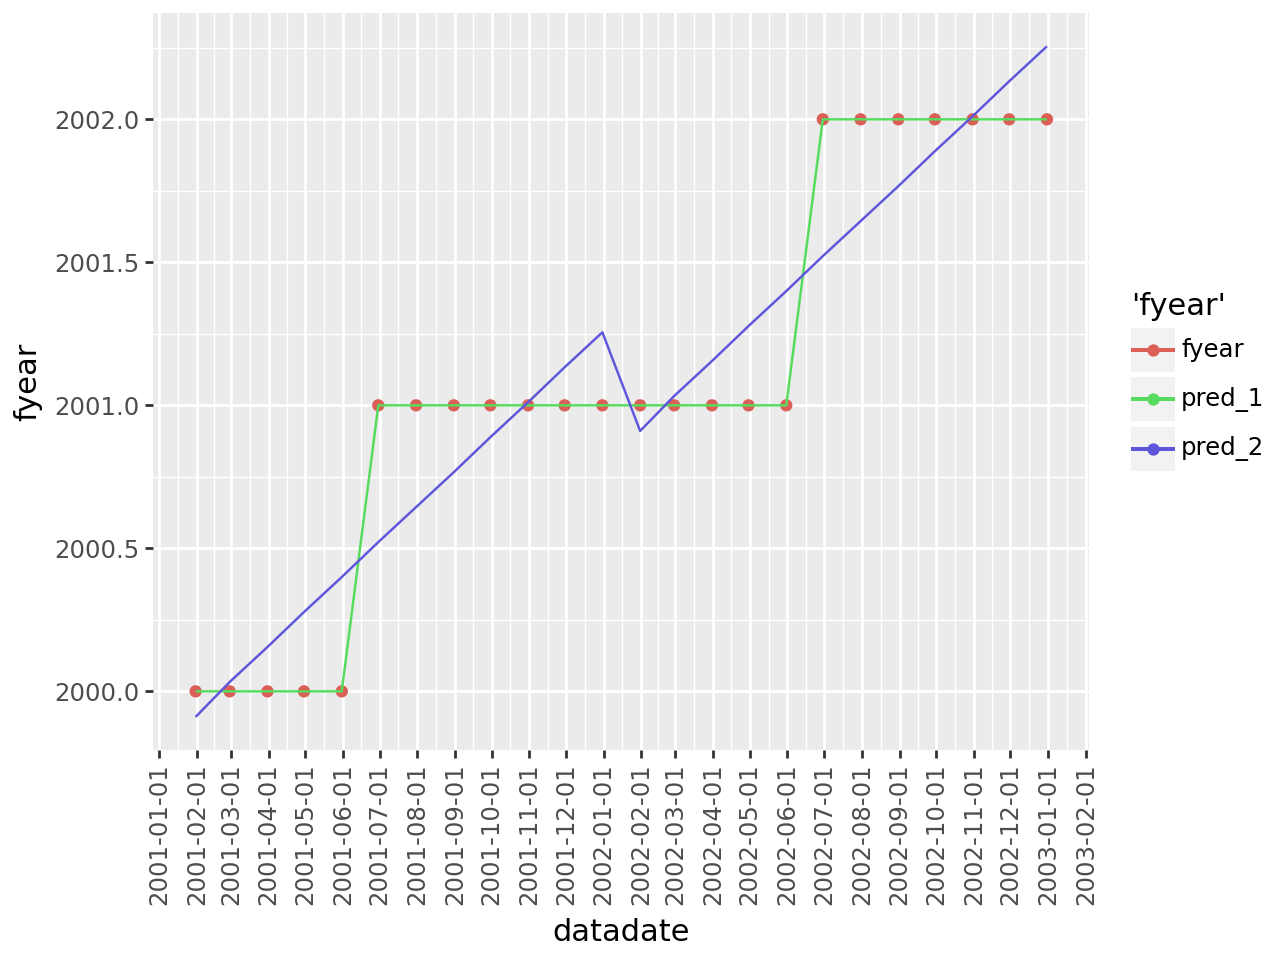

In [159]:
(ggplot(plot_sample, aes(x='datadate')) +
 geom_point(aes(y='fyear', color="'fyear'")) + # 注意和R不同，要写成"'fyear'"，否则会变成连续颜色分类
 geom_line(aes(y='pred_1', color="'pred_1'")) +
 geom_line(aes(y='pred_2', color="'pred_2'")) +
 scale_x_datetime(date_breaks='1 month') +
 theme(axis_text_x=element_text(angle=90)))

我们可以发现，事实上fyear的定义是：当datadate在中的月份在某年的6月之前的话，那么fyear为前一年，否则fyear就是当年。

## 1.2 Exercises

**1. What is different between fms[[1]] and fms[[2]]? What is the function factor() doing here?**

区别其实就是是否把month当作虚拟变量进行回归，factor()函数的作用（Python里是C()函数）的作用就是把month转换为因子，即虚拟变量。

**2.What is the inclusion of - 1 doing in fms[[1]]? Would the omission of - 1 affect the fit of fms[[1]]? Would it affect the interpretability of results? Would the inclusion of - 1 affect the fit of fms[[2]]? Would it affect the interpretability of results?**

-1的作用是不包含截距项，会影响回归1的结果，但不会影响回归2

**3.Does the plot above help understand what’s going on? Why did we focus on a relatively short period in the plot? (Hint: What happens if you remove the line filter(year %in% c(2001, 2002)) |> from the code?)**

- 我们可以发现，事实上fyear的定义是：当datadate在中的月份在某年的1-5月的话，那么fyear为前一年，否则fyear就是当年。

- 选择较短时间段的原因：方便观察，不然太多日期会交叠在一起。

**4.Using year and month, add some code along the lines of mutate(fyear_calc = ...) to calculate fyear. Use this code to create a function fiscal_year(datadate). Check that you match fyear in each case.**

In [177]:
# 计算好估计值
fyear_fit_data = (funda_mod[['fyear','datadate']]
              .drop_duplicates()
              .assign(month = lambda x:x['datadate'].dt.month,
                     year = lambda x:x['datadate'].dt.year)
              .dropna(subset=['fyear'])
              .assign(fyear_calc = fms[0].predict(fyear_data))
             )
# 定义fiscal_year
def fiscal_year(datadate):
    # 直接调用相应的估计值即可
    return round(fyear_fit_data[fyear_fit_data['datadate']==datadate]['fyear_calc'].reset_index(drop=True)[0])

In [180]:
funda_tmp = funda_mod[['fyear','datadate']].head(200) #用200行尝试
funda_tmp['fyear_cal'] = funda_tmp['datadate'].apply(lambda x:fiscal_year(x))
funda_tmp.query('fyear!=fyear_cal') # 找到不相等的行

,fyear,datadate,fyear_cal


# 2 季度数据（Quartly data）

## 2.1 Replication

In [12]:
fundq_mod = (fundq
             .query('indfmt == "INDL" & datafmt == "STD" & consol == "C" & popsrc == "D"')
            )

In [14]:
# 季度数据其实存在重复的gvkey和datadate列
(fundq_mod
 .groupby(['gvkey','datadate'])
 .size().reset_index(name='num_rows')
 .groupby('num_rows').size().reset_index(name='count'))

,num_rows,count
0,1,1996490
1,2,1528


In [57]:
# 寻找重复的数据
fundq_probs = (fundq_mod[fundq_mod.duplicated(subset=['gvkey', 'datadate'], keep=False)] # 直接找出gvkey和datadate有重复的行，减少运行时间
              [['gvkey', 'datadate', 'fyearq', 'fqtr', 'fyr', 'rdq']]
              .sort_values(by=['gvkey', 'datadate'])
              .reset_index(drop=True)
             )

In [16]:
fundq_probs

,gvkey,datadate,fyearq,fqtr,fyr,rdq
0,001076,1995-03-31,1994,4.0,3,1995-05-09
1,001076,1995-03-31,1995,1.0,12,1995-05-09
2,001098,1968-12-31,1969,1.0,9,NaT
3,001098,1968-12-31,1968,4.0,12,NaT
4,001103,1966-12-31,1967,1.0,9,NaT
...,...,...,...,...,...,...
3051,317427,2015-12-31,2015,4.0,12,2016-03-31
3052,330227,2019-03-31,2019,2.0,9,2019-06-03
3053,330227,2019-03-31,2019,1.0,12,2019-06-03
3054,330227,2019-06-30,2019,3.0,9,2019-09-05


In [13]:
# 以代码为001224的股票为例探寻重复的原因
# 首先看年度数据
(funda_mod
 .query("gvkey == '001224' and 2012 <= fyear <= 2015")
 [['gvkey','datadate']]
 .sort_values(by=['gvkey','datadate'])
 .reset_index(drop=True)
)

,gvkey,datadate
0,001224,2012-12-31
1,001224,2013-12-31
2,001224,2014-09-30
3,001224,2015-09-30


在2014年公司把财年结束时间从每年的Q4更换到了每年的Q3，那么2013-12-31既是以2013-12-31为年末的财年的Q4，又是以2014-09-30为年末的财年的Q1。

In [44]:
(fundq_probs
 .query('gvkey=="001224"')
 .sort_values(by=['gvkey','datadate','fqtr'])
 .reset_index(drop=True))

,gvkey,datadate,fyearq,fqtr,fyr,rdq
0,001224,2013-12-31,2014,1.0,9,2014-02-11
1,001224,2013-12-31,2013,4.0,12,2014-02-11
2,001224,2014-03-31,2014,2.0,9,2014-04-30
3,001224,2014-03-31,2014,NaN,12,2014-04-30
4,001224,2014-06-30,2014,3.0,9,2014-08-11
5,001224,2014-06-30,2014,NaN,12,2014-08-11


In [15]:
(fundq_mod
 .groupby(['gvkey', 'datadate', 'fyr']).size().reset_index(name='num_rows')
 .groupby('num_rows').size().reset_index(name='count'))

,num_rows,count
0,1,1999546


In [16]:
(fundq_mod
 [['gvkey', 'datadate', 'fyr']]
 .assign(is_na=lambda x: x.isna().any(axis=1))
 .pipe(lambda df: df[df['is_na']])
 .count()
 .iloc[0]
)
# 这三列是没有缺失值的

0

In [13]:
# 构建连接funda和fundq的连接表
link_table = (fundq_mod
              .rename(columns={'datadate':'datadateq'})
              [['gvkey','datadateq','fyearq','fyr','fqtr']]
              .assign(year = lambda x: np.where(x['fyr']<=5,x['fyearq']+1,x['fyearq'])) # 相当于1-5月结束的财年加1进行还原
              .assign(month = lambda x: x['fyr'].astype(str).str.zfill(2))
              .assign(datadate=lambda x: pd.to_datetime(x['year'].astype(str) + x['month'] + '01', format='%Y%m%d') + pd.offsets.MonthEnd(0))
              .drop(['year', 'month', 'fqtr'], axis=1)
             )

link_table.sort_values(by=['gvkey','datadate']).reset_index(drop=True)

,gvkey,datadateq,fyearq,fyr,datadate
0,001000,1966-03-31,1966,12,1966-12-31
1,001000,1966-06-30,1966,12,1966-12-31
2,001000,1966-09-30,1966,12,1966-12-31
3,001000,1966-12-31,1966,12,1966-12-31
4,001000,1967-03-31,1967,12,1967-12-31
...,...,...,...,...,...
1999541,356128,2022-12-31,2022,12,2022-12-31
1999542,356128,2023-03-31,2023,12,2023-12-31
1999543,356128,2023-06-30,2023,12,2023-12-31
1999544,356128,2023-09-30,2023,12,2023-12-31


## 2.2 Exercises

**1.Pick a couple of gvkey values from fundq_probs. Is it possible to construct a “clean” sequence of quarterly earnings announcements for each of these firms? (Here “clean” means that, at the very least, each quarter shows up just once in the series.) What challenges does one face in this task?**

In [73]:
# 以118574为例
(funda_mod
 .query("gvkey == '118574' and 2007 <= fyear <= 2011")
 [['gvkey','datadate']]
 .sort_values(by=['gvkey','datadate'])
 .reset_index(drop=True)
)
# 2008年进行了会财年调整，因此从2008-06-30开始会有重复记录（2008-03-31不在以2009-03-31为末期的财年，因此不会重复记录）

,gvkey,datadate
0,118574,2007-12-31
1,118574,2009-03-31
2,118574,2010-03-31
3,118574,2011-03-31
4,118574,2012-03-31


In [75]:
# 可以选择仅保留调整后的数据，但这样会损害fqtr的一致性（但fyearq的机制导致其一致性不被影响），这也是处理中可能会遇到的障碍
(fundq_probs[fundq_probs['gvkey']=='118574'].query('fyr==3'))

,gvkey,datadate,fyearq,fqtr,fyr,rdq
2338,118574,2008-06-30,2008,1.0,3,NaT
2340,118574,2008-09-30,2008,2.0,3,NaT
2342,118574,2008-12-31,2008,3.0,3,NaT
2344,118574,2009-03-31,2008,4.0,3,NaT
2346,118574,2009-06-30,2009,1.0,3,NaT
2348,118574,2009-09-30,2009,2.0,3,NaT
2350,118574,2009-12-31,2009,3.0,3,NaT
2352,118574,2010-03-31,2009,4.0,3,NaT
2354,118574,2010-06-30,2010,1.0,3,NaT
2356,118574,2010-09-30,2010,2.0,3,NaT


**2.The code below produces Figure 14.2. From Figure 14.2, it seems that Q2 has been the most profitable on average over the last three decades, while in all decades Q4 has seen the most sales. Can you speculate as to what might explain these facts?**

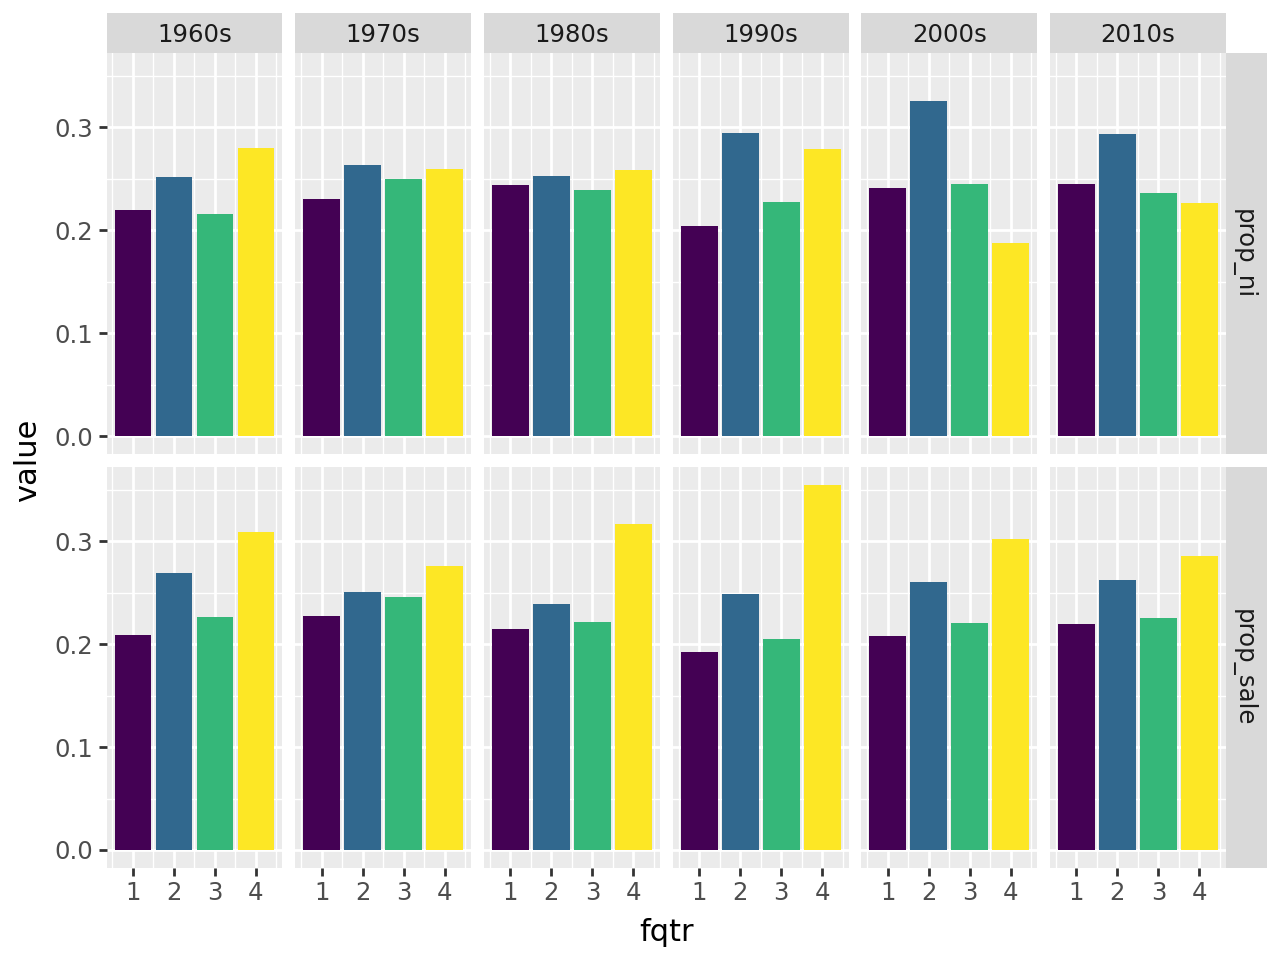

In [14]:
ni_annual = funda_mod[["gvkey", "datadate", "fyr", "sale", "ni"]]

ni_qtrly = fundq_mod[["gvkey", "datadate", "fyr", "fqtr", "saleq", "niq", "ibq"]].rename(columns={'datadate':'datadateq'})

ni_merged = (ni_annual
             .merge(link_table, on=["gvkey", "datadate", "fyr"])
             .merge(ni_qtrly, on=["gvkey", "fyr", "datadateq"]))

plot_data = (ni_merged
             .assign(decade=lambda x: (x["fyearq"] // 10 * 10).astype(str) + "s")
             .query("not fqtr.isna() and fyearq < 2020")
             .groupby(["decade", "fqtr"])
             .agg(sum_ni = ("ni", "sum"),sum_sale=("sale", "sum"),
                  sum_niq=("niq", "sum"), sum_saleq=("saleq", "sum"))
             .assign(prop_ni = lambda x:x['sum_niq']/x['sum_ni'],
                    prop_sale = lambda x:x['sum_saleq']/x['sum_sale'])
             .reset_index()
             .melt(id_vars=["decade", "fqtr"], value_vars=["prop_ni", "prop_sale"], var_name="metric", value_name="value"))

(ggplot(plot_data, aes(x="fqtr", y="value", fill="fqtr")) +
 geom_bar(stat="identity") +
 facet_grid("metric ~ decade") +
 theme(legend_position="none"))

**关于Q2在过去三十年中平均利润最高的可能解释如下：**

- Seasonal Patterns: Q2可能是许多行业的旺季，导致在这个季度内销售额和利润都较高。例如，对于零售业来说，Q2通常包括母亲节和父亲节等购物季节。
- Economic Factors: 在某些行业中，Q2可能与经济活动增加相关。例如，季度末通常是企业报告季度财务状况的时间，这可能会提振商业活动和利润。
- Consumer Behavior: 消费者可能在Q2更愿意花费金钱，例如因为在这个季度有较多的节日或者天气更好，促使他们进行更多的购物。


**至于Q4在所有十年中看到最高销售额的可能解释：**

- Holiday Shopping: Q4通常包括假日购物季节，如感恩节、圣诞节和新年。这些节日期间通常会有更多的消费者购买礼物和商品，因此销售额会达到高峰。
- Year-End Budget Spending: 一些公司可能会在年底花费剩余预算，这可能导致Q4的销售额增加。
- Seasonal Products: 某些产品可能更适合在Q4销售，例如冬季服装、季节性装饰品等，这也可能导致销售额在这个季度更高。

**3.Create another plot using data in ni_merged that you think might be interesting? (Feel free to add variables to ni_annual or ni_qtrly before merging.)**

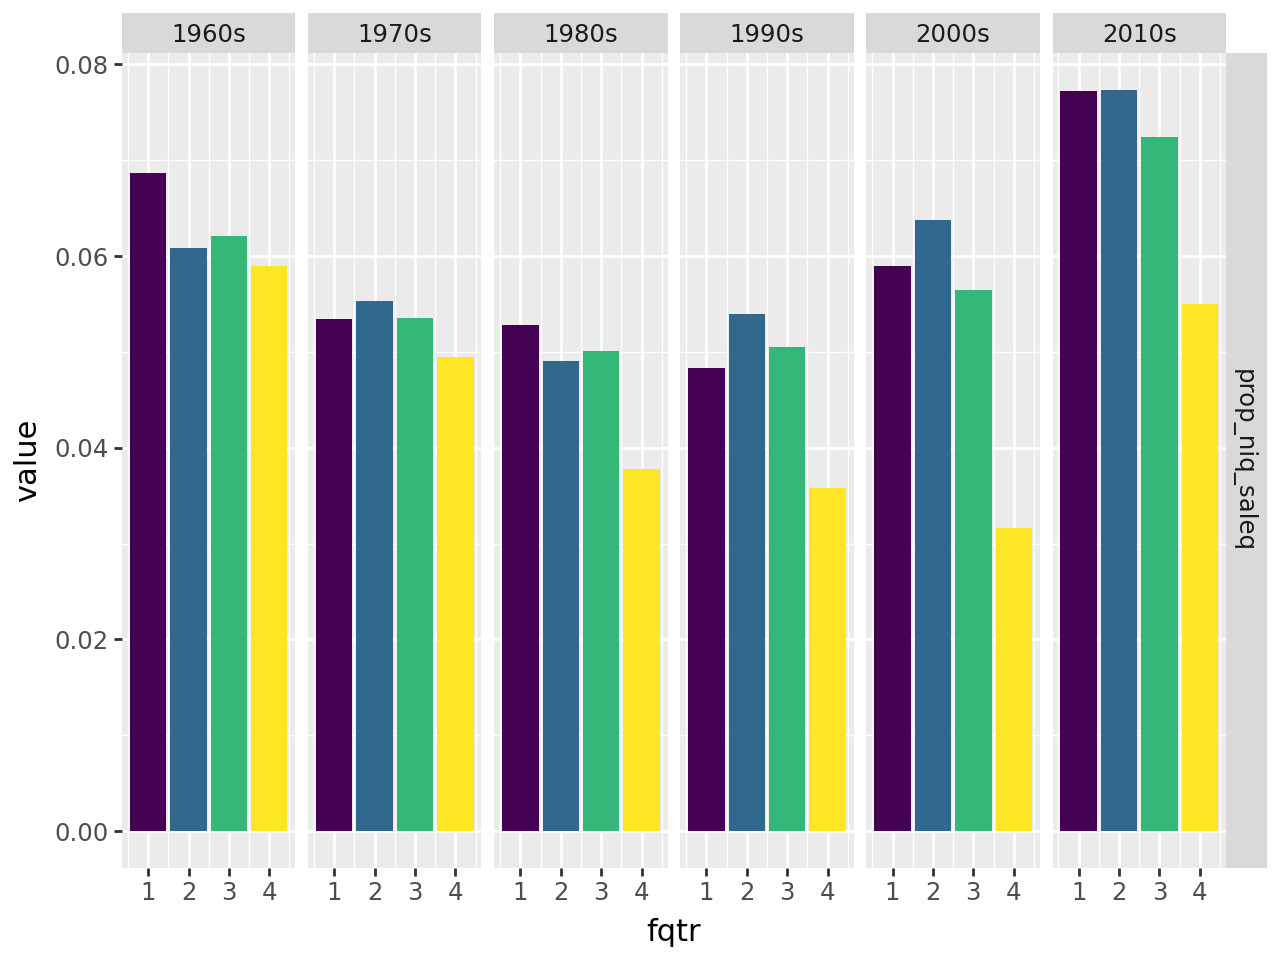

In [55]:
# 计算niq和saleq之比的季度变化
plot_data = (ni_merged
             .assign(decade=lambda x: (x["fyearq"] // 10 * 10).astype(str) + "s")
             .query("not fqtr.isna() and fyearq < 2020")
             .groupby(["decade", "fqtr"])
             .agg(sum_ni = ("ni", "sum"),sum_sale=("sale", "sum"),
                  sum_niq=("niq", "sum"), sum_saleq=("saleq", "sum"))
             .assign(prop_niq_saleq = lambda x:(x['sum_niq']/x['sum_saleq']))
             .reset_index()
             .melt(id_vars=["decade", "fqtr"], value_vars=["prop_niq_saleq"], var_name="metric", value_name="value"))

(ggplot(plot_data, aes(x="fqtr", y="value", fill="fqtr")) +
 geom_bar(stat="identity") +
 facet_grid("metric ~ decade") +
 theme(legend_position="none"))

# 3 Time-series properties of earnings

## 3.1 Replication

Foster（1977）为季度会计变量（销量、净收入和成本）建立了6个预测模型，分别为：

**模型1&2**：将$Q_t$和$Q_{t-4}$的值相联系，构建了季节性模型

Model1：$$E(Q_t)=Q_{t-4}$$
Model2：加入漂移项$\delta$
$$E(Q_t)=Q_{t-4}+ \delta$$ 

**模型3&4**：将$Q_t$和$Q_{t-1}$的收益相联系

Model3：$$E(Q_t)=Q_{t-1}$$
Model4：$$E(Q_t)=Q_{t-1}+ \delta$$ 

**模型5**：在模型2的基础上加入了$\Phi_{1}(Q_{t-1}-Q_{t-5})$

Model5：假设$W_t = Q_t-Q_{t-4}$服从AR(1)过程，则$W_t = \Phi_{1}W_{t-1}+\delta$

$$E(Q_t)=Q_{t-4}+\Phi_{1}(Q_{t-1}-Q_{t-5})+\delta$$

**模型6**：使用了“Box-Jenkins time-series methodology”（Box-Jenkins方法）进行预测

这里我们做了粗略的复制，同时对于模型6的Box-Jenkins方法进行了替换，同时在样本选择上参照Foster的方法设定了样本筛选准则。

In [16]:
n_qtrs = 20 
n_firms = 70
focus_years = [1974,2019] 
sic2s = list(map(str,[29, 49, 28, 35, 32, 33, 37, 20, 26, 10, 36, 59])) 

In [17]:
# 选择sic2s的行业
companies = (
    company
    .assign(sic2=lambda x: x['sic'].astype(str).str[:2])
    .query("sic2 in @sic2s")
    [['gvkey','sic2']]
)

In [21]:
company

,gvkey,sic
0,001000,3089
1,001001,5812
2,001002,3825
3,001003,5712
4,001004,5080
...,...,...
53690,353945,3621
53691,354003,6722
53692,354519,3711
53693,356128,6141


In [18]:
# 剔除掉saleq小于等于0的值以及空值
fundq_local = (
    fundq_mod
    .merge(companies,how='inner',on=['gvkey'])
    .query("saleq > 0 & ~saleq.isna()")
    [['gvkey','datadate','fyr','fqtr','fyearq','rdq','niq','saleq','ibq']]
    .rename(columns={'datadate':'datadateq'})
)

In [27]:
fundq_local

,gvkey,datadateq,fyr,fqtr,fyearq,rdq,niq,saleq,ibq
0,001007,1983-06-30,9,3.0,1983,NaT,-0.314,0.567,-0.314
1,001010,1966-01-31,4,3.0,1965,NaT,2.841,82.400,4.921
2,001010,1966-04-30,4,4.0,1965,NaT,8.133,88.600,8.133
3,001005,1980-07-31,10,3.0,1980,NaT,0.257,6.492,0.257
4,001010,1966-07-31,4,1.0,1966,NaT,6.829,79.200,6.829
...,...,...,...,...,...,...,...,...,...
632720,353444,2023-06-30,12,2.0,2023,2023-08-02,391.808,3597.869,391.808
632721,353444,2023-09-30,12,3.0,2023,2023-11-02,410.716,3124.631,410.716
632722,353444,2023-12-31,12,4.0,2023,2024-02-29,52.460,3980.007,52.460
632726,353945,2021-12-31,12,4.0,2021,NaT,138.508,756.466,138.508


In [19]:
firm_years = funda_mod[['gvkey','datadate']]

# 用之前构造的link_table将funda和fundq相连
merged_data = (
    firm_years
    .merge(link_table,how='inner',on=['gvkey','datadate'])
    .merge(fundq_local,how='inner',on=['gvkey','datadateq','fyearq','fyr'])
)

In [26]:
firm_years

,gvkey,datadate
0,001000,1961-12-31
1,001000,1962-12-31
2,001000,1963-12-31
3,001000,1964-12-31
4,001000,1965-12-31
...,...,...
897553,353742,2022-11-30
897555,353742,2023-11-30
897557,353945,2021-12-31
897558,356128,2022-12-31


In [25]:
merged_data

,gvkey,datadate,datadateq,fyearq,fyr,fqtr,rdq,niq,saleq,ibq
0,001005,1978-10-31,1978-04-30,1978,10,2.0,NaT,-0.083,1.711,-0.083
1,001005,1978-10-31,1978-07-31,1978,10,3.0,NaT,0.066,2.174,0.066
2,001005,1978-10-31,1978-10-31,1978,10,4.0,NaT,0.162,3.007,0.162
3,001005,1978-10-31,1978-01-31,1978,10,1.0,NaT,0.054,1.293,0.054
4,001005,1979-10-31,1979-01-31,1979,10,1.0,NaT,0.036,2.583,0.036
...,...,...,...,...,...,...,...,...,...,...
508755,353444,2023-12-31,2023-03-31,2023,12,1.0,2023-05-03,481.232,3693.981,481.232
508756,353444,2023-12-31,2023-06-30,2023,12,2.0,2023-08-02,391.808,3597.869,391.808
508757,353444,2023-12-31,2023-09-30,2023,12,3.0,2023-11-02,410.716,3124.631,410.716
508758,353444,2023-12-31,2023-12-31,2023,12,4.0,2024-02-29,52.460,3980.007,52.460


In [20]:
# 找出包含四个季度且时间跨度为365天或366天的regular fyears
qtr_num = (
    merged_data
    .groupby(['gvkey','datadate'])
    .size().reset_index(name='num_quarters')
)

regular_fyears = (
    firm_years
    .merge(qtr_num,how='inner',on=['gvkey','datadate'])
    .sort_values(by=['gvkey','datadate'])
    .assign(datadate_lag = lambda x: x.groupby('gvkey')['datadate'].shift(),
            fyear_length = lambda x: x['datadate'] - x['datadate_lag'])
    .assign(regular_year = lambda x: (x['num_quarters'] == 4) & 
            (x['fyear_length'].isna() | x['fyear_length'].isin([pd.Timedelta(days=365),pd.Timedelta(days=366)]))) 
    # 注意365和366要用datetime类型
    .query('regular_year')
    [['gvkey','datadate']]
)

In [24]:
qtr_num

,gvkey,datadate,num_quarters
0,001005,1978-10-31,4
1,001005,1979-10-31,4
2,001005,1980-10-31,4
3,001005,1981-10-31,4
4,001007,1982-09-30,4
...,...,...,...
134195,353444,2021-12-31,4
134196,353444,2022-12-31,4
134197,353444,2023-12-31,4
134198,353945,2021-12-31,1


In [23]:
regular_fyears

,gvkey,datadate
0,001005,1978-10-31
1,001005,1979-10-31
3,001005,1980-10-31
4,001005,1981-10-31
5,001007,1982-09-30
...,...,...
134193,351590,2022-12-31
134194,351590,2023-12-31
134195,353444,2021-12-31
134196,353444,2022-12-31


In [21]:
# 只选择为regular_fyears的样本进行建模
reg_data = (
    merged_data
    .merge(companies[['gvkey']], how='inner', on='gvkey', copy=True)
    .merge(regular_fyears, how='inner', on=['gvkey', 'datadate'])
    .loc[:, ['gvkey', 'datadateq', 'fyearq', 'rdq', 'niq', 'saleq']]
    .sort_values(by='datadateq')
    .assign(sale_lag_1=lambda x: x.groupby('gvkey')['saleq'].shift(1),
            sale_lag_4=lambda x: x.groupby('gvkey')['saleq'].shift(4),
            sale_lag_5=lambda x: x.groupby('gvkey')['saleq'].shift(5),
            sale_diff=lambda x: x['saleq'] - x['sale_lag_1'],
            sale_seas_diff=lambda x: x['saleq'] - x['sale_lag_4'],
            lag_sale_seas_diff=lambda x: x.groupby('gvkey')['sale_seas_diff'].shift(1),
            ni_lag_1=lambda x: x.groupby('gvkey')['niq'].shift(1),
            ni_lag_4=lambda x: x.groupby('gvkey')['niq'].shift(4),
            ni_lag_5=lambda x: x.groupby('gvkey')['niq'].shift(5),
            ni_diff=lambda x: x['niq'] - x['ni_lag_1'],
            ni_seas_diff=lambda x: x['niq'] - x['ni_lag_4'],
            lag_ni_seas_diff=lambda x: x.groupby('gvkey')['ni_seas_diff'].shift(1))
    .reset_index(drop=True)
)

In [22]:
reg_data

,gvkey,datadateq,fyearq,rdq,niq,saleq,sale_lag_1,sale_lag_4,sale_lag_5,sale_diff,sale_seas_diff,lag_sale_seas_diff,ni_lag_1,ni_lag_4,ni_lag_5,ni_diff,ni_seas_diff,lag_ni_seas_diff
0,002102,1961-05-31,1961,NaT,2.010,133.600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,005063,1961-05-31,1961,NaT,0.683,20.400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,009947,1961-06-30,1961,NaT,4.300,265.800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,005055,1961-06-30,1961,NaT,17.196,288.500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,002797,1961-06-30,1961,NaT,2.524,15.800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479363,178704,2024-01-31,2023,2024-03-14,394.369,3554.298,2488.933,3226.773,2338.793,1065.365,327.525,150.140,249.483,340.751,274.585,144.886,53.618,-25.102
479364,117768,2024-01-31,2023,2024-02-21,12285.000,22103.000,18120.000,6051.000,5931.000,3983.000,16052.000,12189.000,9243.000,1414.000,680.000,3042.000,10871.000,8563.000
479365,037502,2024-01-31,2023,2024-03-13,-22.575,1674.476,1494.166,1577.959,1501.220,180.310,96.517,-7.054,-1241.137,32.732,19.920,1218.562,-55.307,-1261.057
479366,015420,2024-01-31,2023,2024-02-27,-60.607,51.616,50.595,83.321,83.096,1.021,-31.705,-32.501,-41.710,-11.105,-19.809,-18.897,-49.502,-21.901


#### 构建fit_model函数的几个点：

**（1）firm_data**：给定gvkey的公司的所有数据

**（2）train_data**：在目标datadateq之前的firm_data，需要包含20个季度的数据

**（3）test_data**：包含目标datdadateq的firm_data，用于模型的预测

**（4）漂移项$\delta$**：直接用训练时间内财务变量的平均相对变化来拟合

**（5）模型6的替代方法**：将模型6视为模型5的“无限制”版本，直接使用$Q_{t}$对$Q_{t-1}$、$Q_{t-4}$和$Q_{t-5}$回归

**（6）abe**：相对百分比误差（Absolute Percentage Error）,同时取绝对值以方便监测异常值

$$abe = |\frac{Q_t-E(Q_t)}{E(Q_t)}|$$

**（7）se**：平方百分比误差（Square Percentage Error）

$$se = (\frac{Q_t-E(Q_t)}{E(Q_t)})^2 = abe^2$$

In [28]:
def fit_model(gvkey, datadateq):
    
    firm_data = reg_data[reg_data['gvkey'] == gvkey]

    train_data = firm_data[(firm_data['datadateq'] < datadateq)].nlargest(n_qtrs, 'datadateq')
    if len(train_data) < n_qtrs:
        return None

    test_data = firm_data[firm_data['datadateq'] == datadateq]

    # 估计模型 2 和 4
    model_24 = (
        train_data
        .groupby('gvkey')
        .agg(sale_diff=('sale_diff', 'mean'),
             ni_diff=('ni_diff', 'mean'),
             sale_seas_diff=('sale_seas_diff', 'mean'),
             ni_seas_diff=('ni_seas_diff', 'mean'))
        .reset_index()
    )

    # 拟合模型 1, 2, 3 和 4
    df_model_1234 = (
        test_data
        .drop(columns=['sale_diff', 'ni_diff', 'sale_seas_diff', 'ni_seas_diff'])
        .merge(model_24, on='gvkey', how='inner')
        .assign(ni_m1=lambda x: x['ni_lag_4'],
                sale_m1=lambda x: x['sale_lag_4'],
                ni_m2=lambda x: x['ni_lag_4'] + x['ni_seas_diff'],
                sale_m2=lambda x: x['sale_lag_4'] + x['sale_seas_diff'],
                ni_m3=lambda x: x['ni_lag_1'],
                sale_m3=lambda x: x['sale_lag_1'],
                ni_m4=lambda x: x['ni_lag_1'] + x['ni_diff'],
                sale_m4=lambda x: x['sale_lag_1'] + x['sale_diff'])
    )

    # 拟合模型 5
    sale_fm5 = None
    ni_fm5 = None
    try:
        sale_fm5 = LinearRegression().fit(train_data[['lag_sale_seas_diff']], train_data['sale_seas_diff'])
        ni_fm5 = LinearRegression().fit(train_data[['lag_ni_seas_diff']], train_data['ni_seas_diff'])
    except Exception as e:
        pass

    # 拟合模型 6
    sale_fm6 = None
    ni_fm6 = None
    try:
        sale_fm6 = LinearRegression().fit(train_data[['sale_lag_1', 'sale_lag_4', 'sale_lag_5']], train_data['saleq'])
        ni_fm6 = LinearRegression().fit(train_data[['ni_lag_1', 'ni_lag_4', 'ni_lag_5']], train_data['niq'])
    except Exception as e:
        pass

    if sale_fm5 is not None and ni_fm5 is not None:
        results = (
            df_model_1234
            .assign(ni_m5=lambda x: x['ni_lag_4'] + ni_fm5.predict(test_data[['lag_ni_seas_diff']]))
            .assign(sale_m5=lambda x: x['sale_lag_4'] + sale_fm5.predict(test_data[['lag_sale_seas_diff']]))
            .assign(ni_m6=lambda x: ni_fm6.predict(test_data[['ni_lag_1', 'ni_lag_4', 'ni_lag_5']]))
            .assign(sale_m6=lambda x: sale_fm6.predict(test_data[['sale_lag_1', 'sale_lag_4', 'sale_lag_5']]))
            [['gvkey','datadateq','fyearq','niq','saleq',
              'ni_m1','ni_m2','ni_m3','ni_m4','ni_m5','ni_m6','sale_m1','sale_m2','sale_m3','sale_m4','sale_m5','sale_m6']]
            .melt(id_vars = ['gvkey','datadateq','fyearq','niq','saleq'],var_name='item_', value_name='value')
            .assign(abe=lambda x: np.where(x['item_'].str.contains('^ni'), 
                                           abs(x['value'] - x['niq']) / x['value'], abs(x['value'] - x['saleq']) / x['value']))
            .assign(se=lambda x: x['abe']**2)
            .assign(item=lambda x: x['item_'].str.split('_m',expand=True)[0],
                    model=lambda x: x['item_'].str.split('_m',expand=True)[1])
            .drop(columns=['item_','niq', 'saleq'])
        )

        return results
    else:
        return None

In [29]:
# 选取销量前70名的公司
top_firms = (
    reg_data
    .loc[reg_data['fyearq'].isin(focus_years)]
    .groupby(['gvkey', 'fyearq'])
    .agg(total_sales=('saleq', 'sum'))
    .reset_index()
    .sort_values(by=['total_sales'], ascending=False)
    .assign(rank=lambda x: x.groupby('fyearq').cumcount() + 1)
    .query('rank <= @n_firms')
)

# 只保留gvkey和datadateq两列
test_years = (
    reg_data
    .merge(top_firms[['gvkey', 'fyearq']], on=['gvkey', 'fyearq'], how='inner')
    [['gvkey', 'datadateq']]
)

In [45]:
test_years.reset_index(drop=True)

,gvkey,datadateq
0,008762,1973-09-30
1,006765,1973-10-31
2,008331,1973-10-31
3,008935,1973-12-31
4,002157,1973-12-31
...,...,...
555,007114,2020-03-31
556,005691,2020-03-31
557,019113,2020-03-31
558,019661,2020-03-31


In [234]:
# 直接循环
start_time = time()
count = 1
for _, row in test_years.iterrows():
    if count == 1:
        results = fit_model(row['gvkey'], row['datadateq'])
    else:
        results = pd.concat([results,fit_model(row['gvkey'], row['datadateq'])],ignore_index=True)
    count = count + 1
time() - start_time

49.58283495903015

In [241]:
# 使用joblib的Parallel函数并行处理
start_time = time()
tmp_results = Parallel(n_jobs=-1)(delayed(fit_model)(row['gvkey'],row['datadateq']) for _,row in test_years.iterrows())
results = pd.concat(tmp_results, ignore_index=True)
time() - start_time

69.9785487651825

In [46]:
# 使用map函数
start_time = time()
results = pd.concat(map(fit_model,test_years['gvkey'],test_years['datadateq']),ignore_index=True).reset_index(drop=True)
time() - start_time

54.99220395088196

In [47]:
results

,gvkey,datadateq,fyearq,value,abe,se,item,model
0,008762,1973-09-30,1974,91.628000,0.061018,0.003723,ni,1
1,008762,1973-09-30,1974,96.740100,0.110638,0.012241,ni,2
2,008762,1973-09-30,1974,53.029000,0.622452,0.387446,ni,3
3,008762,1973-09-30,1974,53.039650,0.622126,0.387041,ni,4
4,008762,1973-09-30,1974,96.341383,0.106957,0.011440,ni,5
...,...,...,...,...,...,...,...,...
6127,009818,2020-03-31,2019,18952.906900,0.110907,0.012300,sale,2
6128,009818,2020-03-31,2019,22461.584000,0.249791,0.062395,sale,3
6129,009818,2020-03-31,2019,22657.986300,0.256294,0.065686,sale,4
6130,009818,2020-03-31,2019,18570.715636,0.092610,0.008577,sale,5


In [48]:
# 过滤异常值
def fix_outliers(x):
    return np.where((x < 0) | (x > 1), 1, x)      

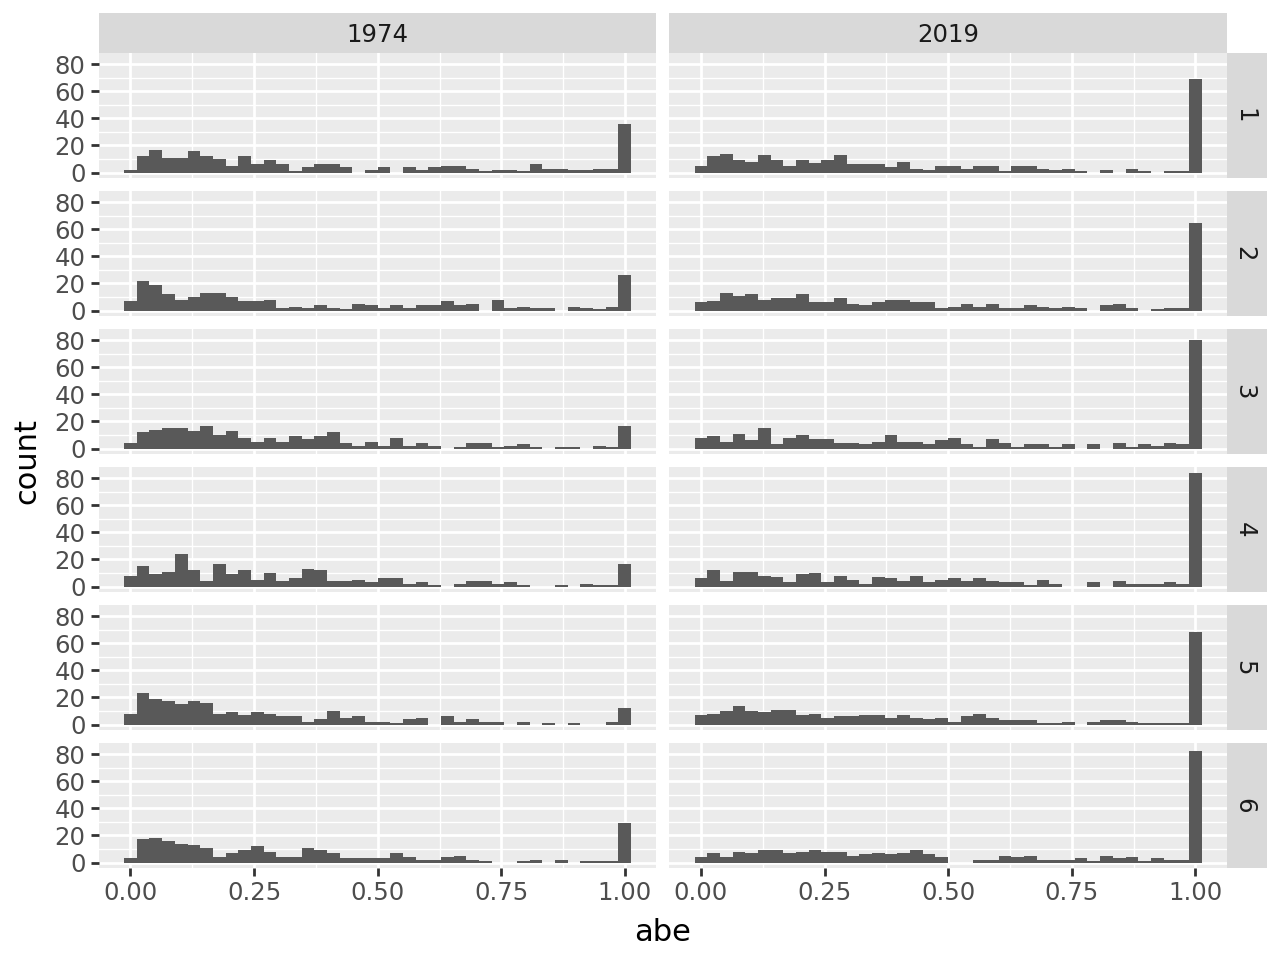

In [49]:
# 画abe的分布图
results_plot =  (
    results
    .query('item == "ni" & ~abe.isna()')  
    .assign(abe=lambda x: fix_outliers(x['abe']))
)

(ggplot(results_plot, aes(x='abe')) + 
 geom_histogram(bins=40) + 
 facet_grid('model ~ fyearq', drop=True))

In [50]:
# 根据abe进行排序，计算每个模型的avg_rank
model_ranks = (
    results
    .sort_values(by=['gvkey','datadateq','item','abe'])
    .assign(rank=lambda x: x.groupby(['gvkey','datadateq','item']).cumcount() + 1)
    .groupby(['fyearq', 'item', 'model'])
    .agg(avg_rank=('rank', 'mean'))
    .reset_index()
    .pivot(index=['fyearq', 'item'], columns='model', values='avg_rank')
    .reset_index()
)

In [52]:
model_ranks

model,fyearq,item,1,2,3,4,5,6
0,1974,ni,4.213992,3.432099,3.493827,3.399177,2.954733,3.506173
1,1974,sale,5.510288,4.098765,3.267490,2.674897,2.563786,2.884774
2,2019,ni,3.272388,3.343284,3.503731,3.772388,3.324627,3.783582
3,2019,sale,3.500000,3.511194,3.701493,3.697761,3.421642,3.167910


In [53]:
# 计算mabe和mse
results_summ = (
    results
    .assign(abe=lambda x: fix_outliers(x['abe']),
            se=lambda x: fix_outliers(x['se']))
    .groupby(['fyearq', 'item', 'model'])
    .agg(mabe=('abe', 'mean'),
         mse=('se', 'mean'))
    .reset_index()
)

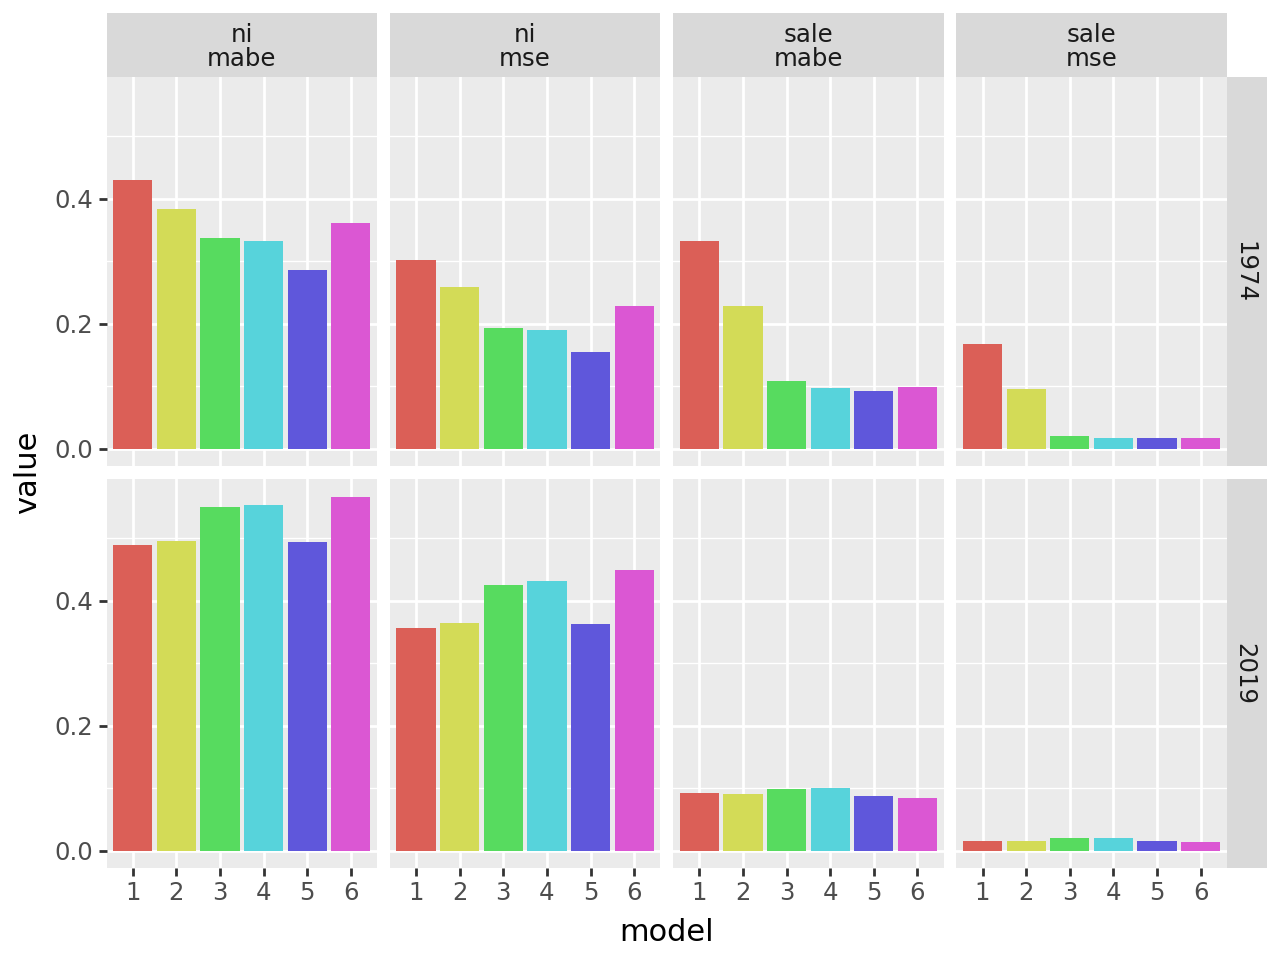

In [54]:
results_summ_plot =  results_summ.melt(id_vars=['fyearq', 'item', 'model'], value_vars=['mabe', 'mse'], var_name='metric', value_name='value')
(ggplot(results_summ_plot,aes(x = 'model', y = 'value', fill = 'model')) +
  geom_bar(stat = "identity") +
  facet_grid('fyearq ~ item + metric') +
  theme(legend_position='none')
)

## 3.2 Exercises

**1.How do the denominators in our calculations of abe and se differ from those in the analogous calculations in Foster (1977)? Is one approach to the denominator more correct than the other?**

这里的计算使用预测值作为分母，而Foster用的实际值，前者是实际值相对于预测值的偏离程度，后者是预测值相对于实际值的偏离程度，都可以衡量模型的拟合优度，没有完全的对错之分。

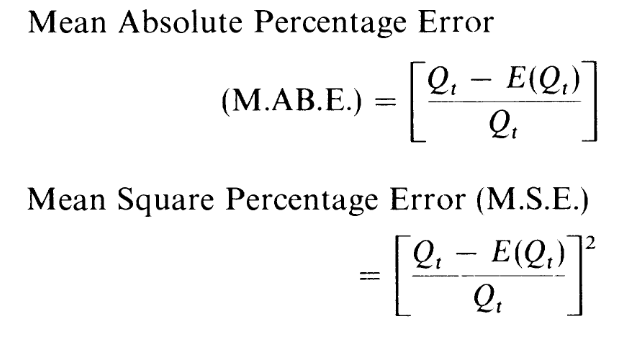

**2.What does fix_outliers() do? Does Foster (1977) do anything to address outliers? If so, how does the approach in Foster (1977) compare to that of fix_outliers()? Do you agree with the approach taken in fix_outliers()? What would you do differently?**

去除abe和se中的异常值，Foster（1977）也有类似的做法，他将abe和se计算过程中分母为负值的情况或者计算结果大于100%的情况全部设定为100%。

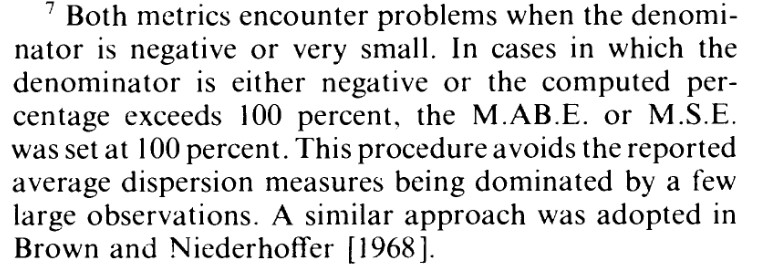

**3.How do the results in Figure 14.4 compare with those in Foster (1977)?**

（1）Foster（1977）的主要结果为：

- 结论1：对于所有三个序列，模型 5（AR(1)模型）在每个财政季度的平均排名中均最高，表明它在预测未来值方面表现最好。特别是，模型 5 在所有季度合并考虑时的平均排名为 2.710，而模型 6（一个更为复杂的 Box-Jenkins 模型）的平均排名为 3.598。

- 结论2：对于收益序列，包含季节性因素的朴素模型（模型 1 和 2）比非季节性朴素模型（模型 3 和 4）具有更高的排名，这表明季节性因素对于预测收益序列是重要的。

- 结论3：包含漂移项（drift term）的模型通常比没有包含漂移项的对应模型具有更高的平均排名，这表明随着时间的推移，收益、销售和费用系列预期会呈现上升趋势（可能是由于公司收益再投资或通货膨胀的影响）。

（2）与我们的结论对比：

- 在1974年的样本中，结论1、2、3都是成立的。

- 在2019年的样本中，结论1和2依然成立，结论3不一定成立，即加入漂移项不一定能改进模型的预测能力。

In [89]:
# 我们的结果
model_ranks

model,fyearq,item,1,2,3,4,5,6
0,1974,ni,4.213992,3.432099,3.493827,3.399177,2.954733,3.506173
1,1974,sale,5.510288,4.098765,3.267490,2.674897,2.563786,2.884774
2,2019,ni,3.272388,3.343284,3.503731,3.772388,3.324627,3.783582
3,2019,sale,3.500000,3.511194,3.701493,3.697761,3.421642,3.167910


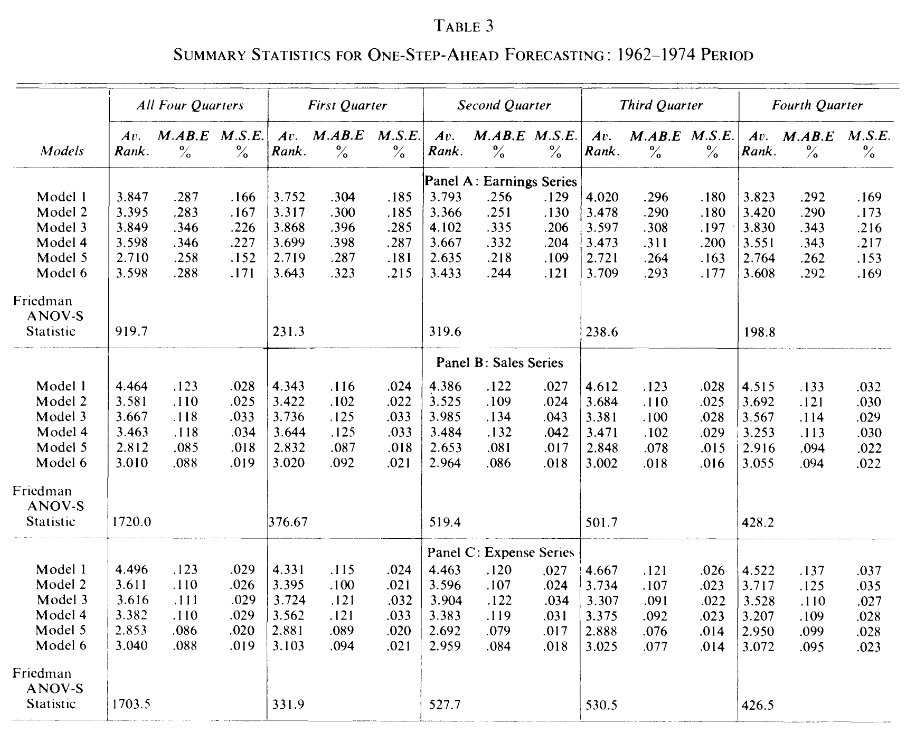

**4.What do you make of the significantly “worse” performance of models predicting ni than those predicting sale? Does this imply that ni is simply more difficult to forecast? Can you suggest an alternative approach to measuring performance that might place these models on a more “level playing field”?**

- 模型在预测ni（净收入）时表现出相对较差的性能，而在预测sale（销售额）时性能较好，这可能确实意味着预测ni本身就比预测sale更加困难。一般来说，净收入受到公司运营的多种复杂因素影响，包括销售额、成本、税收、非经常性项目等，这些因素可能会增加预测难度。相比之下，销售额作为一个直接的收入指标，可能受到的影响因素相对较少，因此更容易预测。
- 可以考虑利用信息准则，如AIC（赤池信息准则）或BIC（贝叶斯信息准则），比较模型的拟合优度，并对模型复杂性进行惩罚。这有助于在考虑了模型复杂性后确定一个模型相对于另一个模型的改进性能是否显著。

# 4 Post-earnings announcement drift

## 4.1 Replication

Bernard and Thomas (1989)对Earning surprise的两种衡量方法：

$$FE_{i}^1 = \frac{Q_{i,t}-E[Q_{i,t}]}{|Q_{i,t}|}$$

$$FE_{i}^2 = \frac{Q_{i,t}-E[Q_{i,t}]}{\sigma(Q_{i,t}-E[Q_{i,t}])} $$

这里继续使用上面定义的Model1和Model5，使用规则为：

**（1）需要最多24个季度的观测值的训练集来进行模型的训练**。

**（2）当训练集的有效观测值小于10个时，直接不进行拟合**。

**（3）当训练集的有效观测值小于16个时，使用Model1进行拟合和预测**。

**（4）当训练集的有效观测值大于等于16个时，使用Model5进行拟合和预测**。


但这里不再使用Net Income，而是使用Income Before Extraodinary Item（ibq）。

In [31]:
reg_data_fos =(
    merged_data
    .merge(regular_fyears,on=['gvkey','datadate'],how='inner')
    [['gvkey','datadateq','fyearq','rdq','ibq']]
    .sort_values(by=['datadateq'])
    .assign(ib_lag_4 = lambda x: x.groupby('gvkey')['ibq'].shift(4),
           ib_seas_diff = lambda x: x['ibq'] - x['ib_lag_4'],
           lag_ib_seas_diff = lambda x:x.groupby('gvkey')['ib_seas_diff'].shift(1),
           qtr = lambda x:x['datadateq'].dt.to_period("Q"))
)

In [32]:
reg_data_fos

,gvkey,datadateq,fyearq,rdq,ibq,ib_lag_4,ib_seas_diff,lag_ib_seas_diff,qtr
22012,002102,1961-05-31,1961,NaT,2.010,NaN,NaN,NaN,1961Q2
86516,005063,1961-05-31,1961,NaT,0.683,NaN,NaN,NaN,1961Q2
198680,009947,1961-06-30,1961,NaT,4.300,NaN,NaN,NaN,1961Q2
86301,005055,1961-06-30,1961,NaT,17.196,NaN,NaN,NaN,1961Q2
36174,002797,1961-06-30,1961,NaT,2.524,NaN,NaN,NaN,1961Q2
...,...,...,...,...,...,...,...,...,...
461139,178704,2024-01-31,2023,2024-03-14,394.369,340.751,53.618,-25.102,2024Q1
413399,117768,2024-01-31,2023,2024-02-21,12285.000,1414.000,10871.000,8563.000,2024Q1
365583,037502,2024-01-31,2023,2024-03-13,-22.575,32.732,-55.307,-1261.057,2024Q1
284055,015420,2024-01-31,2023,2024-02-27,-60.607,-11.105,-49.502,-21.901,2024Q1


In [33]:
def fit_model_fos(gvkey, quarter):
    n_qtrs = 24
    min_qtrs_fos = 16
    min_qtrs = 10
    
    firm_data = reg_data_fos[reg_data_fos['gvkey'] == gvkey]
    
    train_data = firm_data[(firm_data['qtr'] < quarter)].nlargest(n_qtrs, 'datadateq')
    
    test_data = firm_data[firm_data['qtr'] == quarter]
    
    if len(train_data) < min_qtrs:
        return None
    
    if len(train_data) >= min_qtrs_fos:
        train_data2 = train_data.dropna(subset = ['ib_seas_diff','lag_ib_seas_diff'])
        if len(train_data2) > 0:
            ib_fm = sm.formula.ols(formula='ib_seas_diff ~ lag_ib_seas_diff', data=train_data2).fit()
        else:
            ib_fm = None
    else:
        ib_fm = None
    
    if ib_fm is not None:
        train_results = train_data.copy()
        train_results['fib'] = train_data['ib_lag_4'] + ib_fm.predict(train_data[['lag_ib_seas_diff']])
    else:
        train_results = train_data.copy()
        train_results['fib'] = train_data['ib_lag_4']
    
    # FE2的分母使用训练集来进行计算
    # python里面会忽略NaN值来计算标准差
    if ((train_results['ibq'] - train_results['fib']).isna()).any():
        denom_m2 = float('nan')
    else:
        denom_m2 = np.std(train_results['ibq'] - train_results['fib'])
    
    # FE1、FE2的分子使用测试集来进行计算
    if ib_fm is None:
        results = test_data.copy()
        results['fib'] = test_data['ib_lag_4']
    else:
        results = test_data.copy()
        results['fib'] = test_data['ib_lag_4'] + ib_fm.predict(test_data[['lag_ib_seas_diff']])
    
    # 注意python在分母为0时会返回inf，但我们需要NaN
    results['fe1'] = np.where(results['ibq'] != 0, (results['ibq'] - results['fib']) / np.abs(results['ibq']), np.nan)
    results['fe2'] = (results['ibq'] - results['fib']) / denom_m2
    
    return results

In [34]:
# 这里选择1974-1986年的数据
quarters = (
    reg_data_fos[(reg_data_fos['qtr']>= pd.Period("1974Q1", freq="Q-DEC")) 
                 & (reg_data_fos['qtr']< pd.Period("1987Q1", freq="Q-DEC"))]['qtr'].unique() # 已经自动排序
           )

In [35]:
quarters

<PeriodArray>
['1974Q1', '1974Q2', '1974Q3', '1974Q4', '1975Q1', '1975Q2', '1975Q3',
 '1975Q4', '1976Q1', '1976Q2', '1976Q3', '1976Q4', '1977Q1', '1977Q2',
 '1977Q3', '1977Q4', '1978Q1', '1978Q2', '1978Q3', '1978Q4', '1979Q1',
 '1979Q2', '1979Q3', '1979Q4', '1980Q1', '1980Q2', '1980Q3', '1980Q4',
 '1981Q1', '1981Q2', '1981Q3', '1981Q4', '1982Q1', '1982Q2', '1982Q3',
 '1982Q4', '1983Q1', '1983Q2', '1983Q3', '1983Q4', '1984Q1', '1984Q2',
 '1984Q3', '1984Q4', '1985Q1', '1985Q2', '1985Q3', '1985Q4', '1986Q1',
 '1986Q2', '1986Q3', '1986Q4']
Length: 52, dtype: period[Q-DEC]

In [36]:
# 先定义get_results函数，完成每个季度所有公司的拟合
def get_results(quarter):
    gvkeys = reg_data_fos[reg_data_fos['qtr'] == quarter]['gvkey'].unique()
    quarter_ = [quarter] * len(gvkeys)
    results = pd.concat(map(fit_model_fos,gvkeys,quarter_)).reset_index(drop=True)
    return results

In [114]:
# 可以先尝试运行一个季度的结果，观察一下运行时间
start_time = time()
tmp = get_results(quarters[0])
time() - start_time

85.41079258918762

In [76]:
# 使用joblib的Parallel和delayed来并行处理每个季度的数据
def process_quarter(quarter):
    result = get_results(quarter)
    return result

start_time = time()
tmp_results = Parallel(n_jobs=-1)(delayed(process_quarter)(quarter) for quarter in quarters)
results = pd.concat(tmp_results, ignore_index=True)# 合并所有结果
time() - start_time

544.126757144928

Bernard和Thomas(1989)基于意外收益的十分位数形成了投资组合。同时为了避免前瞻性偏误（lookahead bias），这里将基于上一个季度意外收益的分布来将将公司分配到不同的十分位数区间内。

In [78]:
# 获取每个季度所有fe1和fe2中的十分位数分割
def get_deciles(x):
    breaks = np.nanquantile(x, q=np.arange(0, 1.1, 0.1), axis=0)
    breaks[-1] = np.inf
    return breaks.tolist()

decile_cuts = (
    results
    .groupby('qtr')
    .agg(fe1_deciles=('fe1', lambda x: get_deciles(x)),
         fe2_deciles=('fe2', lambda x: get_deciles(x)))
    .reset_index()
    .sort_values('qtr')
    .assign(fe1_deciles_lag=lambda x: x['fe1_deciles'].shift(),
            fe2_deciles_lag=lambda x: x['fe2_deciles'].shift())
)

decile_cuts.fillna(value=np.nan, inplace=True)

In [79]:
decile_cuts.head(10)

,qtr,fe1_deciles,fe2_deciles,fe1_deciles_lag,fe2_deciles_lag
0,1974Q1,"[-52.22052960372542, -1.0941353979753714, -0.4...","[-20.453632443781462, -2.6260819428502375, -1....",NaN,NaN
1,1974Q2,"[-24.221450081531522, -0.7959492866733562, -0....","[-16.139776279512592, -1.7556109636119963, -0....","[-52.22052960372542, -1.0941353979753714, -0.4...","[-20.453632443781462, -2.6260819428502375, -1...."
2,1974Q3,"[-287.77777777777777, -1.0138702636045573, -0....","[-47.23706634475522, -2.246524983398272, -1.15...","[-24.221450081531522, -0.7959492866733562, -0....","[-16.139776279512592, -1.7556109636119963, -0...."
3,1974Q4,"[-197.43775475217885, -2.0659435445343526, -0....","[-22.879388790872063, -4.132257360077498, -2.5...","[-287.77777777777777, -1.0138702636045573, -0....","[-47.23706634475522, -2.246524983398272, -1.15..."
4,1975Q1,"[-141.0994821208317, -1.8923161494992555, -0.8...","[-13.650300044377996, -3.393478866695117, -2.2...","[-197.43775475217885, -2.0659435445343526, -0....","[-22.879388790872063, -4.132257360077498, -2.5..."
5,1975Q2,"[-169.3855306787193, -1.3828279848786942, -0.6...","[-9.810515828526608, -2.7002880596061662, -1.7...","[-141.0994821208317, -1.8923161494992555, -0.8...","[-13.650300044377996, -3.393478866695117, -2.2..."
6,1975Q3,"[-41.38731143517375, -1.1204441172783517, -0.3...","[-14.711237105939912, -1.963667850722212, -1.0...","[-169.3855306787193, -1.3828279848786942, -0.6...","[-9.810515828526608, -2.7002880596061662, -1.7..."
7,1975Q4,"[-37.91771871685175, -0.9884829777663833, -0.3...","[-34.803895341081095, -2.22988312055929, -1.09...","[-41.38731143517375, -1.1204441172783517, -0.3...","[-14.711237105939912, -1.963667850722212, -1.0..."
8,1976Q1,"[-337.15617815122704, -0.685943445207209, -0.1...","[-13.075499415483385, -1.293664190259075, -0.5...","[-37.91771871685175, -0.9884829777663833, -0.3...","[-34.803895341081095, -2.22988312055929, -1.09..."
9,1976Q2,"[-13.41427545754306, -0.5906621754001637, -0.2...","[-27.427041910386908, -1.6353190197862215, -0....","[-337.15617815122704, -0.685943445207209, -0.1...","[-13.075499415483385, -1.293664190259075, -0.5..."


In [80]:
# 获取每个股票fe1和fe2在当季度所有fe1和fe2中的十分位数区间
results_deciles = (pd.merge(results, decile_cuts, on='qtr', how='inner')
                   .assign(fe1_decile=lambda df: df.apply(lambda row: pd.cut([row['fe1']], bins=row['fe1_deciles_lag'], labels=False)[0]+1 
                                                          if (pd.notnull(row['fe1'])&~np.isnan(row['fe1_deciles_lag']).all()) 
                                                          else np.nan, axis=1),
                           fe2_decile=lambda df: df.apply(lambda row: pd.cut([row['fe2']], bins=row['fe2_deciles_lag'], labels=False)[0]+1 
                                                          if (pd.notnull(row['fe2'])&~np.isnan(row['fe2_deciles_lag']).all()) 
                                                          else np.nan, axis=1))
                   .dropna(subset=['fe1_decile', 'fe2_decile'], how='all',axis=0)
                   .drop(columns={'fe1_deciles', 'fe2_deciles','fe1_deciles_lag', 'fe2_deciles_lag'})
                   .reset_index(drop=True)
                  )

In [81]:
results_deciles

,gvkey,datadateq,fyearq,rdq,ibq,ib_lag_4,ib_seas_diff,lag_ib_seas_diff,qtr,fib,fe1,fe2,fe1_decile,fe2_decile
0,004207,1974-04-30,1974,1974-05-22,5.291,4.576,0.715,0.962,1974Q2,5.377806,-0.016406,NaN,6.0,NaN
1,005813,1974-04-30,1974,1974-05-29,1.088,0.872,0.216,0.405,1974Q2,1.194633,-0.098008,NaN,4.0,NaN
2,010594,1974-04-30,1974,1974-05-30,-0.067,-0.216,0.149,-0.010,1974Q2,-0.291208,3.346392,NaN,10.0,NaN
3,011001,1974-04-30,1974,1974-05-21,0.699,0.503,0.196,0.122,1974Q2,0.606037,0.132995,NaN,8.0,NaN
4,003969,1974-04-30,1973,1974-07-29,0.176,0.135,0.041,-0.198,1974Q2,0.135000,0.232955,NaN,8.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64776,007368,1986-12-31,1986,NaT,0.682,0.737,-0.055,0.179,1986Q4,0.828703,-0.215106,NaN,4.0,NaN
64777,002262,1986-12-31,1986,NaT,0.916,0.743,0.173,0.473,1986Q4,0.993053,-0.084119,-0.243692,4.0,4.0
64778,004383,1986-12-31,1987,1987-02-11,1.372,2.039,-0.667,-1.500,1986Q4,2.039000,-0.486152,NaN,3.0,NaN
64779,010466,1986-12-31,1987,1987-02-04,-6.003,-9.488,3.485,-2.958,1986Q4,-18.879077,2.144940,0.724630,9.0,8.0


In [82]:
# 使用ccmpf_lnkhist数据库构造link_table来连接公司和股票
ccm_link = ccmxpf_lnkhist.loc[
    ccmxpf_lnkhist['linktype'].isin(["LC", "LU", "LS"]) &
    ccmxpf_lnkhist['linkprim'].isin(["C", "P"])
].assign(
    linkenddt=lambda x: x['linkenddt'].fillna(x['linkenddt'].max())
).rename(columns={'lpermno': 'permno'})

link_table = (
    results_deciles[['gvkey', 'rdq']]
    .merge(ccm_link, how='inner',left_on='gvkey', right_on='gvkey',suffixes=('_results', '_ccm'))
    .loc[lambda x: (x['rdq'] >= x['linkdt']) & (x['rdq'] <= x['linkenddt'])]
    [['gvkey', 'rdq', 'permno']]
)

In [83]:
link_table

,gvkey,rdq,permno
0,004207,1974-05-22,40141
2,004207,1974-10-03,40141
4,004207,1974-11-26,40141
6,004207,1975-02-27,40141
8,004207,1975-05-30,40141
...,...,...,...
83402,003370,1987-01-29,86941
83403,003889,1987-01-14,87266
83404,003796,1987-01-28,12005
83407,004476,1987-02-10,87696


In [84]:
# 计算link_table中公司发布财务报告前后60天公司对应市值分位数组合的平均收益率，即rets
# R代码中rets数据框由farr包中的get_event_rets函数计算得出，主要涉及farr包中其他函数和wrds中数据库的调用，需要到服务器的电脑中进行运行运行
# 直接读入存在pead文件中存放好的rets数据
rets = pd.read_sql_query(sql='SELECT * FROM rets',
                                   con=pead,
                                   dtype={"permno": str},
                                   parse_dates={'rdq', 'start_date','end_date','date'})

In [85]:
rets

,rdq,permno,start_date,end_date,date,ret,decret,vwretd,relative_td
0,1974-05-09,27318,1974-02-12,1974-08-05,1974-02-12,0.027273,-0.002927,0.000565,-60
1,1974-05-09,27318,1974-02-12,1974-08-05,1974-02-13,0.013274,-0.001066,-0.000072,-59
2,1974-05-09,27318,1974-02-12,1974-08-05,1974-02-14,0.004367,0.003445,0.000466,-58
3,1974-05-09,27318,1974-02-12,1974-08-05,1974-02-15,0.008696,0.011602,0.013283,-57
4,1974-05-09,27318,1974-02-12,1974-08-05,1974-02-19,0.008621,-0.000600,-0.000808,-56
...,...,...,...,...,...,...,...,...,...
6434825,1987-06-18,33655,1987-03-24,1987-09-14,1987-09-08,0.000000,-0.014893,-0.012709,56
6434826,1987-06-18,33655,1987-03-24,1987-09-14,1987-09-09,0.000000,0.002586,0.002231,57
6434827,1987-06-18,33655,1987-03-24,1987-09-14,1987-09-10,0.000000,0.003128,0.009396,58
6434828,1987-06-18,33655,1987-03-24,1987-09-14,1987-09-11,-0.016949,0.005337,0.013199,59


##### rets数据说明

- rdq：报告日期（Report Date for Quarterly Data）。表示公司发布季度财务报告的日期。

- permno：CRSP分配给公司的唯一标识符，称为公司永久编号（Permanent Number）

- start_date：窗口起始日

- end_date：窗口结束日

- date：数据日期

- ret：股票的收益率（return）

- decret：股票对应市值分位数组合的正常收益率（decile return）

- vwretd：市值加权的组合收益率（value weighted return with divendens）

- relative_td：数据日期相对于rdq的天数

In [86]:
plot_data = (
    results_deciles
    .dropna(subset=['rdq'])
    .assign(datadateq_max=lambda x: x.groupby(['gvkey', 'rdq'])['datadateq'].transform('max'))
    .query("datadateq == datadateq_max")
    .assign(decile=lambda x: x['fe2_decile'])
    .merge(link_table, on=['gvkey', 'rdq'], how='inner')
    .merge(rets, on=['rdq', 'permno'], how='inner')
    .assign(ret_decret = lambda x:x['ret']-x['decret'])
    .groupby(['decile', 'relative_td'])
    .agg({col: 'mean' for col in ['ret_decret']}) # 计算ar
    .rename(columns = {'ret_decret':'ar'})
    .reset_index()
)

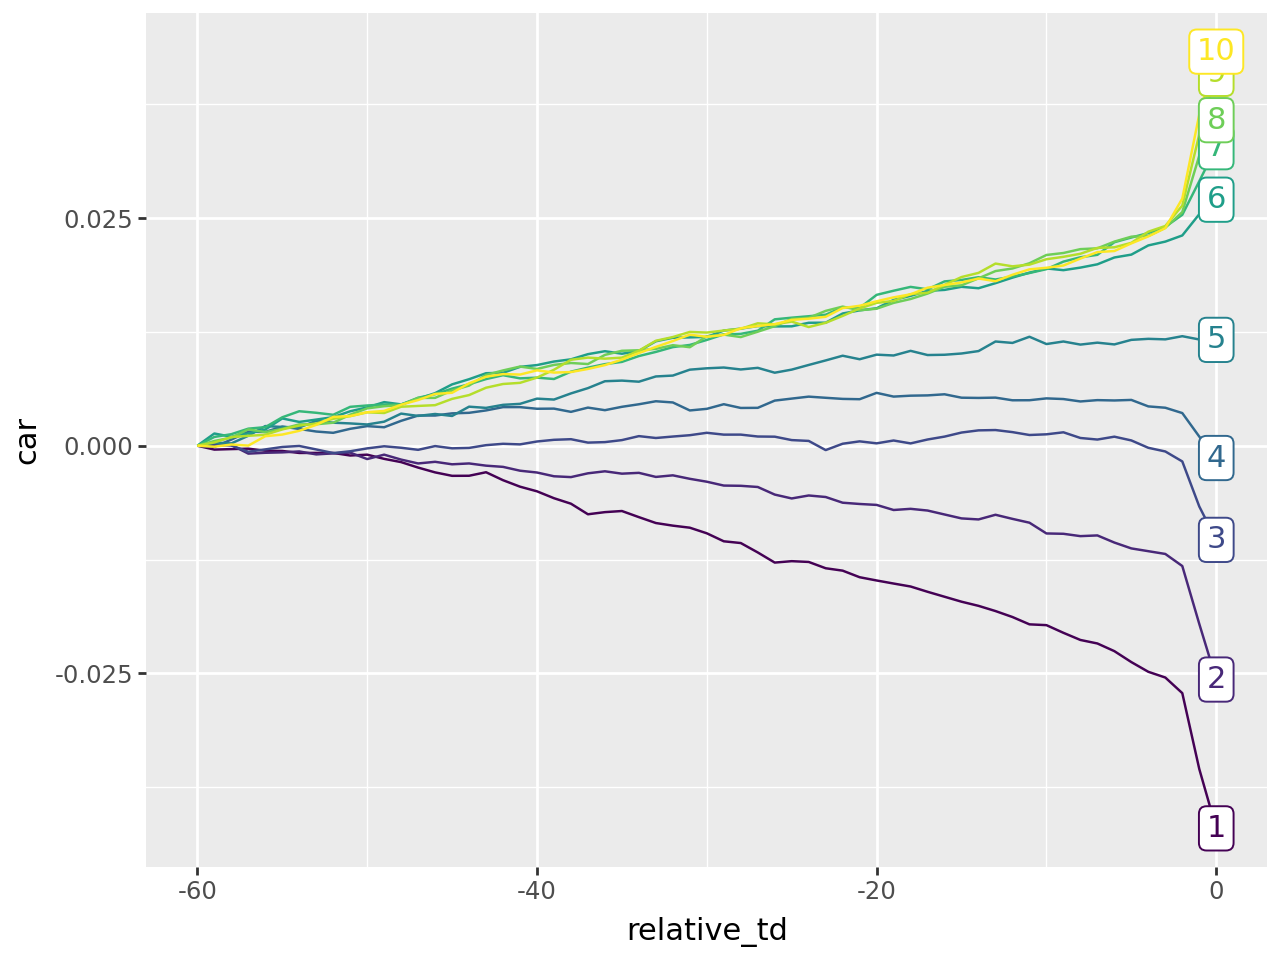

In [38]:
plot_data_1 = (
    plot_data
    .query("relative_td <= 0")
    .dropna(subset=['decile'])
    .assign(first_day=lambda df: df['relative_td'] == df['relative_td'].min(),
            last_day=lambda df: df['relative_td'] == df['relative_td'].max(),
            ar=lambda df: df['ar'].where(~df['first_day'], 0),
            label=lambda df: df['decile'].astype(int).astype(str).where(df['last_day'], pd.NA))
    .drop(columns=['first_day'])
    .sort_values(by='relative_td')
    .assign(car=lambda df: df.groupby('decile')['ar'].cumsum())
)

(ggplot(plot_data_1,aes(x='relative_td', y='car', group='decile', color='decile')) + 
    geom_line() + 
    geom_label(aes(label='label'), na_rm=True) + 
    theme(legend_position='none'))

### 对应的R的结果

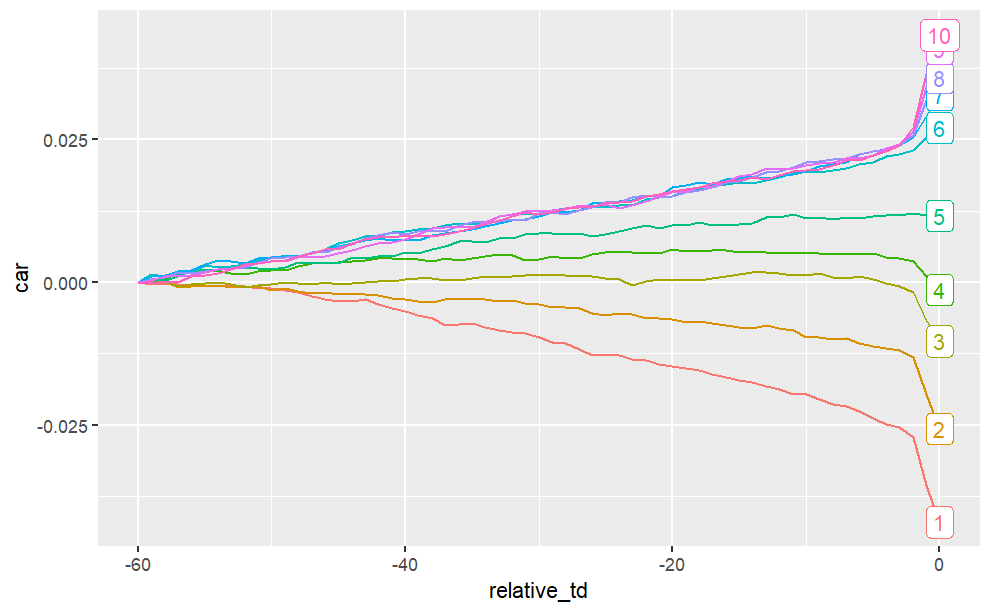

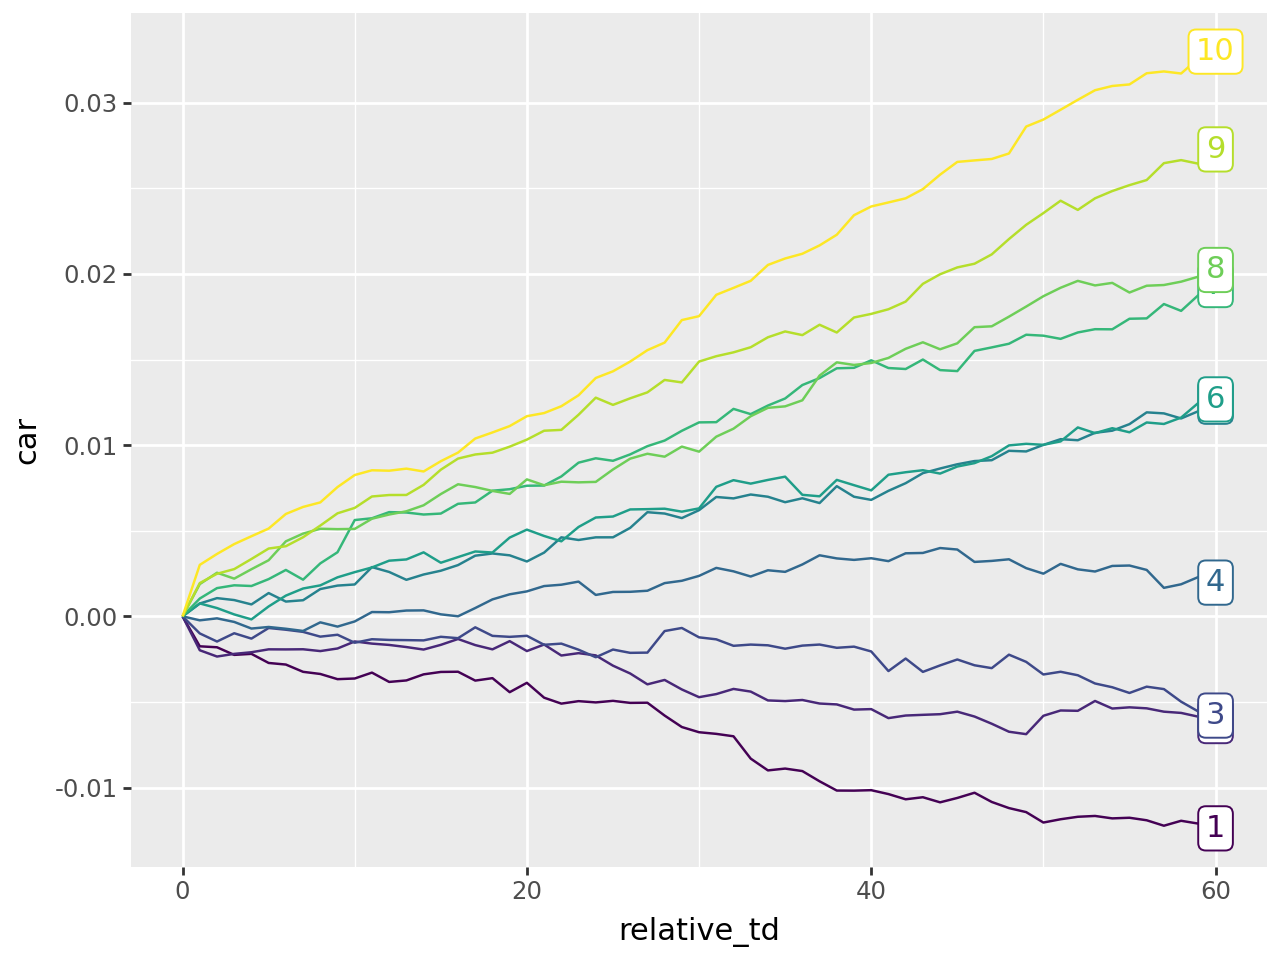

In [39]:
plot_data_2 = (
    plot_data
    .query("relative_td >= 0")
    .dropna(subset=['decile'])
    .assign(first_day=lambda df: df['relative_td'] == df['relative_td'].min(),
            last_day=lambda df: df['relative_td'] == df['relative_td'].max(),
            ar=lambda df: df['ar'].where(~df['first_day'], 0),
            label=lambda df: df['decile'].astype(int).astype(str).where(df['last_day'], pd.NA))
    .sort_values(by='relative_td')
    .assign(car=lambda df: df.groupby('decile')['ar'].cumsum())
)

(ggplot(plot_data_2,aes(x='relative_td', y='car', group='decile', color='decile')) + 
    geom_line() + 
    geom_label(aes(label='label'), na_rm=True) + 
    theme(legend_position='none'))

### 对应的R的结果

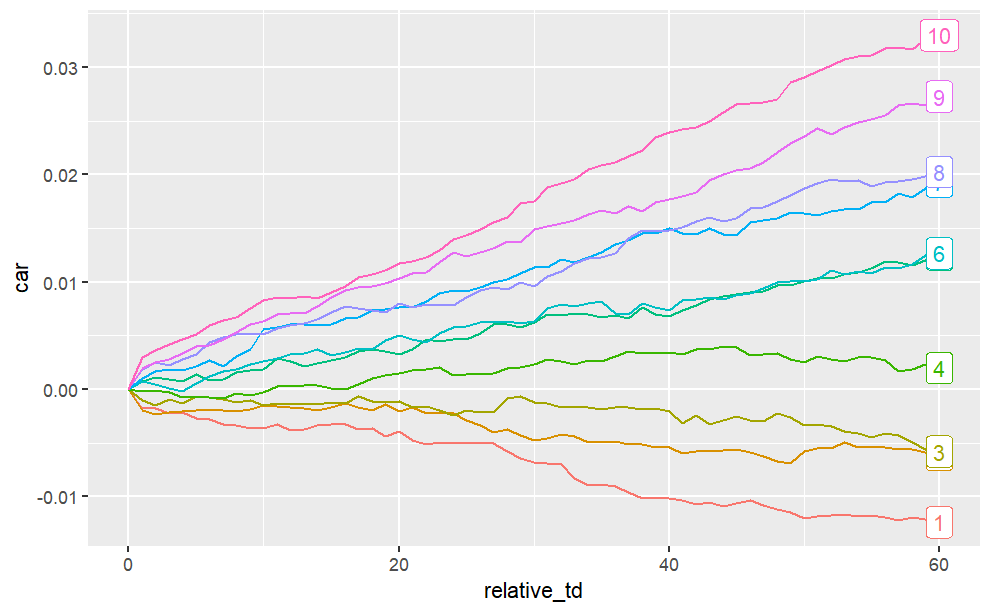

## 4.2 Exercise

**1.A common feature of Bernard and Thomas (1989) and Ball and Brown (1968), is that both were addressing issues with “conventional wisdom” at their respective times. How had conventional wisdom changed in the years between 1968 and 1989?**

- **Ball and Brown（1968）**：他们所挑战的“传统观点”（conventional wisdom）与围绕会计收入数字对投资决策和资本市场效率的有用性和相关性的怀疑有关。当时的传统观点认为会计数字（或多或少）是毫无意义的。


- **Bernard and Thomas（1989）**：他们所挑战的传统观点（conventional wisdom）是，即使在财报发布之后，股价仍会继续朝着财报消息的方向波动(上涨代表“好消息”，下跌代表“坏消息”)。这种漂移与有效市场假说相矛盾，有效市场假说认为，所有可获得的信息都会立即反映在股价上。

**2.Evaluate the introduction of Bernard and Thomas (1989). How clear is the research question to you from reading this? How does this introduction compare with other papers we’ve read in the course? With other papers you have seen?**

Bernar and Thomas(1989)的介绍提出了一个明确而集中的研究问题。**作者的目的是区分“收益公告后漂移”(PEAD)现象的两种相互竞争的解释。PEAD指的是在盈利消息发布后的一段时间内，股价继续朝着盈利消息的方向移动(利好消息上涨，负面消息下跌)。**

他们考虑的两种解释是:

- **延迟的价格反应**：这表明价格对公司收益的新信息的部分反应是延迟的，可能是由于交易者需要时间来吸收信息，或者因为成本阻止了对信息的立即交易。

- **风险溢价**：这种解释假设观察到的漂移实际上是对资本资产定价模型(CAPM)未捕获的一些风险的公平补偿。在这种观点下，异常收益并不是真正的异常，而是投资者为承担未被发现的风险而要求的额外收益。

Bernard和Thomas(1989)构建了他们的引言，提供了PEAD现象的背景，总结了当前的理解状态，并提出了延迟价格响应和CAPM错误规范的论点。然后他们概述论文的结构，表明他们将描述他们的样本和方法，总结他们的测试，并讨论证据和结论。研究问题的清晰性来自作者对两个相互竞争的假设的精确描述，以及他们对这些假设进行实证检验的承诺。他们还为这个问题的重要性提供了一个基本原理，讨论了对市场效率和会计收益相关性的影响。综上所述，引言通过提供上下文，澄清问题中的现象，确立研究的意义，有效地设定了研究问题。引言的结构和流程引导读者理解研究的目的和作者想要回答的具体问题。

**3.How persuasive do you find Bernard and Thomas (1989) to be? (Obviously answering this one requires reading the paper fairly closely.)**

从Bernard和Thomas(1989)文章的结构和内容来看，他们的内容存在一定的说服性：

（1）**研究问题的清晰度**：他们清楚地定义了研究问题，即区分收益公告后漂移(PEAD)的延迟价格反应和风险溢价解释。

（2）**方法的严谨性** ：他们采用了强有力的实证方法，将统计测试应用于收益公告和股票回报的大型数据集。这种方法是系统和透明的，这增强了他们的发现的说服力。

（3）**数据分析**：他们分析了12年期间的大量公司季度样本，由于广泛的市场覆盖和时间跨度，这为他们的结果提供了可信度。

（4）**反驳和稳健性检查**：它们解决了潜在的反驳，例如交易成本的作用和资本资产定价模型(CAPM)未捕获的风险因素的可能性。他们还通过将结果与其他模型和策略进行比较来执行鲁棒性检查。

（5）**未回答的问题**：尽管他们倾向于支持价格反应延迟的解释，但Bernard 和 Thomas 也提出了一些未解决的问题，例如为什么市场似乎对可以预测的收益信息感到惊讶，以及为什么大部分PEAD现象集中在下一个季度收益公告的时期。

**4.The analysis above considers the 13-year period from 1974 to 1986. What changes would you need to make to the code to run the analysis for the 13-year period from 2007 to 2019? (If you choose to make this change and run the code, what do you notice about the profile of returns in the post-announcement period? Does it seem necessary to make an additional tweak to the code to address this?)**

**代码需要改变两个地方：第一是quarters重新选择时间范围，第二是重新计算rets（这里省略rets计算的代码），最后呈现的规律基本相同。**

In [85]:
# 这里选择2007-2019年的数据
quarters = (
    reg_data_fos[(reg_data_fos['qtr']>= pd.Period("2007Q1", freq="Q-DEC")) 
                 & (reg_data_fos['qtr']< pd.Period("2020Q1", freq="Q-DEC"))]['qtr'].unique() # 已经自动排序
           )

# 拟合
tmp_results = Parallel(n_jobs=-1)(delayed(process_quarter)(quarter) for quarter in quarters)
results = pd.concat(tmp_results, ignore_index=True)# 合并所有结果

# 分位数
decile_cuts = (
    results
    .groupby('qtr')
    .agg(fe1_deciles=('fe1', lambda x: get_deciles(x)),
         fe2_deciles=('fe2', lambda x: get_deciles(x)))
    .reset_index()
    .sort_values('qtr')
    .assign(fe1_deciles_lag=lambda x: x['fe1_deciles'].shift(),
            fe2_deciles_lag=lambda x: x['fe2_deciles'].shift())
)

decile_cuts.fillna(value=np.nan, inplace=True)

results_deciles = (pd.merge(results, decile_cuts, on='qtr', how='inner')
                   .assign(fe1_decile=lambda df: df.apply(lambda row: pd.cut([row['fe1']], bins=row['fe1_deciles_lag'], labels=False)[0]+1 
                                                          if (pd.notnull(row['fe1'])&~np.isnan(row['fe1_deciles_lag']).all()) 
                                                          else np.nan, axis=1),
                           fe2_decile=lambda df: df.apply(lambda row: pd.cut([row['fe2']], bins=row['fe2_deciles_lag'], labels=False)[0]+1 
                                                          if (pd.notnull(row['fe2'])&~np.isnan(row['fe2_deciles_lag']).all()) 
                                                          else np.nan, axis=1))
                   .dropna(subset=['fe1_decile', 'fe2_decile'], how='all',axis=0)
                   .drop(columns={'fe1_deciles', 'fe2_deciles','fe1_deciles_lag', 'fe2_deciles_lag'})
                   .reset_index(drop=True)
                  )

# 连接表
link_table = (
    results_deciles[['gvkey', 'rdq']]
    .merge(ccm_link, how='inner',left_on='gvkey', right_on='gvkey',suffixes=('_results', '_ccm'))
    .loc[lambda x: (x['rdq'] >= x['linkdt']) & (x['rdq'] <= x['linkenddt'])]
    [['gvkey', 'rdq', 'permno']]
)

# 绘图数据
plot_data = (
    results_deciles
    .dropna(subset=['rdq'])
    .assign(datadateq_max=lambda x: x.groupby(['gvkey', 'rdq'])['datadateq'].transform('max'))
    .query("datadateq == datadateq_max")
    .assign(decile=lambda x: x['fe2_decile'])
    .merge(link_table, on=['gvkey', 'rdq'], how='inner')
    .merge(rets, on=['rdq', 'permno'], how='inner')
    .assign(ret_decret = lambda x:x['ret']-x['decret'])
    .groupby(['decile', 'relative_td'])
    .agg({col: 'mean' for col in ['ret_decret']}) # 计算ar
    .rename(columns = {'ret_decret':'ar'})
    .reset_index()
)

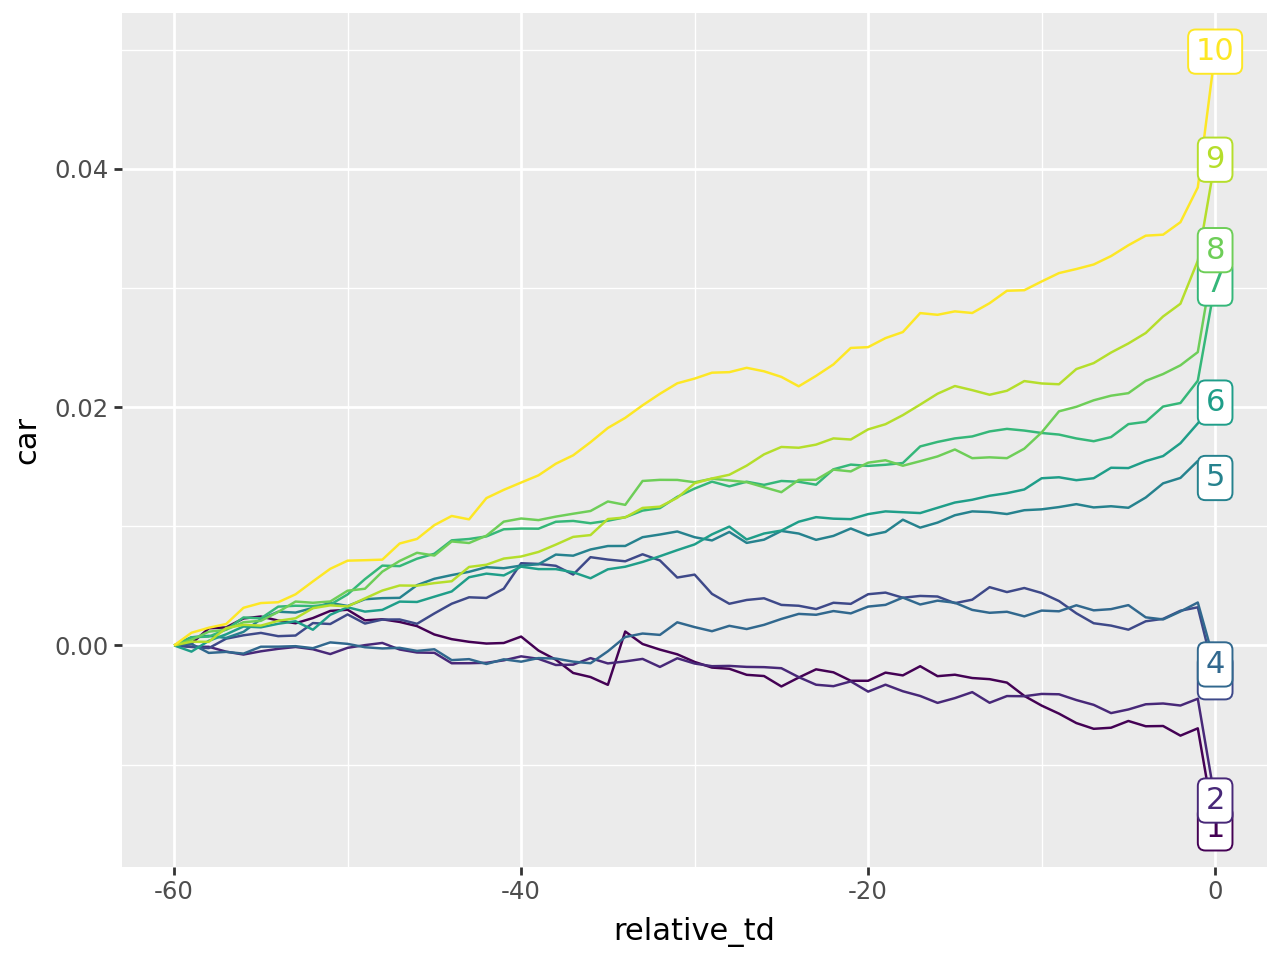

In [87]:
plot_data_1 = (
    plot_data
    .query("relative_td <= 0")
    .dropna(subset=['decile'])
    .assign(first_day=lambda df: df['relative_td'] == df['relative_td'].min(),
            last_day=lambda df: df['relative_td'] == df['relative_td'].max(),
            ar=lambda df: df['ar'].where(~df['first_day'], 0),
            label=lambda df: df['decile'].astype(int).astype(str).where(df['last_day'], pd.NA))
    .drop(columns=['first_day'])
    .sort_values(by='relative_td')
    .assign(car=lambda df: df.groupby('decile')['ar'].cumsum())
)

(ggplot(plot_data_1,aes(x='relative_td', y='car', group='decile', color='decile')) + 
    geom_line() + 
    geom_label(aes(label='label'), na_rm=True) + 
    theme(legend_position='none'))

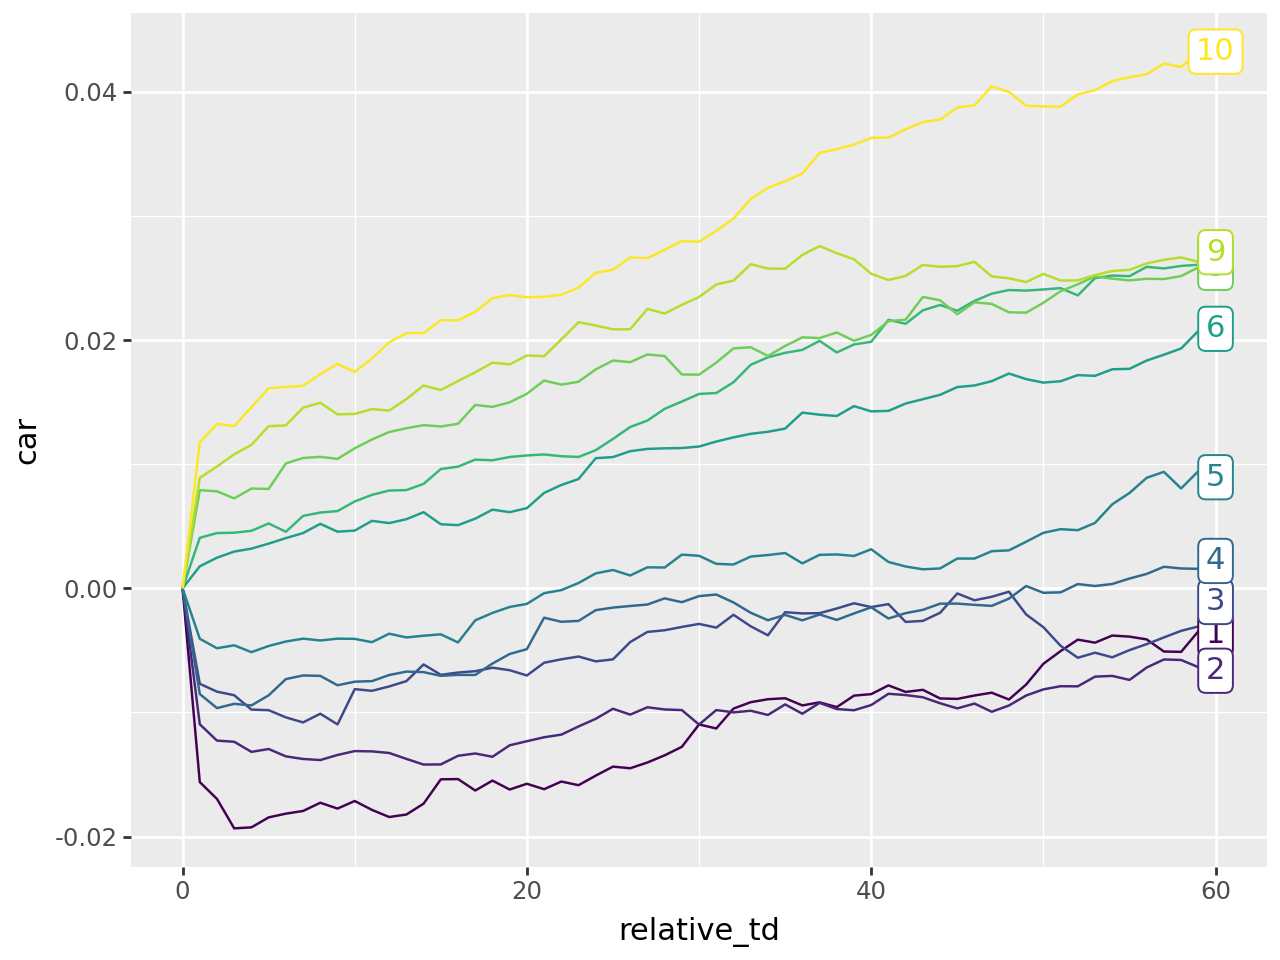

In [88]:
plot_data_2 = (
    plot_data
    .query("relative_td >= 0")
    .dropna(subset=['decile'])
    .assign(first_day=lambda df: df['relative_td'] == df['relative_td'].min(),
            last_day=lambda df: df['relative_td'] == df['relative_td'].max(),
            ar=lambda df: df['ar'].where(~df['first_day'], 0),
            label=lambda df: df['decile'].astype(int).astype(str).where(df['last_day'], pd.NA))
    .sort_values(by='relative_td')
    .assign(car=lambda df: df.groupby('decile')['ar'].cumsum())
)

(ggplot(plot_data_2,aes(x='relative_td', y='car', group='decile', color='decile')) + 
    geom_line() + 
    geom_label(aes(label='label'), na_rm=True) + 
    theme(legend_position='none'))

**5.Considering a single stock, what trading strategy is implicit in calculating ar as ret - decret?**

**单只股票的交易策略**：买入该股票，并同时卖空对应市值分位数的投资组合（或者理解为卖空类似市值的公司的股票）

**6.In calculating mean returns by decile and relative_td (i.e., first using group_by(decile, relative_td) and then calculating ar by aggregating mean(ret - decret, na.rm = TRUE)), are we making assumptions about the trading strategy? What issues are created by this trading strategy? Can you suggest an alternative trading strategy? What changes to the code would be needed to implement this alternative?**

（1）**对交易策略的假设**：等权重买入该市值分位数下的所有股票来构成一个组合

（2）**可能的问题**：并不是总能等权重买入所有股票

（3）**改进方法**：可以按照市值加权买入该市值分位数下的所有股票

**7.Is it appropriate to add returns to get cumulative abnormal returns as is done in car = cumsum(ar)? What would be one alternative approach?**

- 因为我们关注的时间段比较短（前后分别60天），因此将收益相加是合理的。
- 其他方法有：（1）将（1+ar）直接累乘再减一计算car；（2）分别采用累乘计算股票（累计）收益和正常（累计）收益，再相减